In [1]:
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, concatenate, LSTM, Add, Multiply, Layer
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
import numpy as np
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils import plot_model
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from utils import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [2]:
H = K.constant([[1, 1]])
SNR1 = 7
SNR2 = 7
SNRs = [SNR1, SNR2]
ebno = [calc_ebno(SNR) for SNR in SNRs]

k = 2
n_channel = 2
M = 2 ** k
k = int(k)
R = k / n_channel

In [23]:
input_signal1 = Input(shape=(M,), name="input1")
input_signal2 = Input(shape=(M,), name="input2")
encoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder1")
encoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder2")

combiner = Sequential([
    Dense(n_channel, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="combiner")

signal_input1 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1"
)

signal_input2 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

decoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder1")

decoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder2")

In [12]:
x1 = encoder1(input_signal1)
x2 = encoder2(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

model.compile(optimizer="adam", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            30          input1[0][0]                     
__________________________________________________________________________________________________
encoder2 (Sequential)           (None, 2)            30          input2[0][0]                     
____________________________________________________________________________________________

In [15]:
train_datas = generate_train_datas()

model.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="loss", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    AlphaCallback(alpha)
])

Train on 200000 samples, validate on 200000 samples
Epoch 1/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2873 - decoder2_loss: 0.2862 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0265 - val_decoder1_loss: 0.0266 - val_decoder2_loss: 0.0265 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 2/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2876 - decoder2_loss: 0.2851 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0262 - val_decoder1_loss: 0.0256 - val_decoder2_loss: 0.0268 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 3/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.

200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2852 - decoder2_loss: 0.2856 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0268 - val_decoder1_loss: 0.0269 - val_decoder2_loss: 0.0267 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 40/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2875 - decoder2_loss: 0.2847 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0272 - val_decoder1_loss: 0.0272 - val_decoder2_loss: 0.0272 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 41/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2859 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2856 - decoder2_loss: 0.2866 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0279 - val_decoder1_loss: 0.0282 - val_decoder2_loss: 0.0276 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 78/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2854 - decoder2_loss: 0.2864 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8830 - decoder2_BER: 0.0585 - val_loss: 0.0278 - val_decoder1_loss: 0.0280 - val_decoder2_loss: 0.0277 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 79/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2874 - decoder2_loss: 0.2862 - decoder1_acc: 0.8822 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2886 - decoder2_loss: 0.2851 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0282 - val_decoder1_loss: 0.0281 - val_decoder2_loss: 0.0284 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 116/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2855 - decoder2_loss: 0.2867 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.0281 - val_decoder1_loss: 0.0283 - val_decoder2_loss: 0.0279 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 117/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2878 - decoder1_loss: 0.2882 - decoder2_loss: 0.2874 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2871 - decoder1_loss: 0.2856 - decoder2_loss: 0.2886 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.0285 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 154/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2880 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0284 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 155/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2884 - decoder2_loss: 0.2866 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2847 - decoder2_loss: 0.2850 - decoder1_acc: 0.8833 - decoder1_BER: 0.0584 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0285 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 192/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2869 - decoder2_loss: 0.2846 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 193/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2877 - decoder2_loss: 0.2862 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2858 - decoder2_loss: 0.2862 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 230/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2873 - decoder2_loss: 0.2866 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 231/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2868 - decoder2_loss: 0.2864 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2861 - decoder2_loss: 0.2862 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 268/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2862 - decoder2_loss: 0.2861 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 269/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2865 - decoder1_loss: 0.2869 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2874 - decoder2_loss: 0.2871 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 306/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2847 - decoder2_loss: 0.2855 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 307/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2865 - decoder2_loss: 0.2854 - decoder1_acc: 0.8831 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2884 - decoder2_loss: 0.2832 - decoder1_acc: 0.8821 - decoder1_BER: 0.0590 - decoder2_acc: 0.8848 - decoder2_BER: 0.0576 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 344/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2867 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 345/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2877 - decoder2_loss: 0.2856 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2851 - decoder2_loss: 0.2845 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 382/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2877 - decoder2_loss: 0.2849 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 383/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2880 - decoder2_loss: 0.2864 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2867 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0587 - decoder2_acc: 0.8839 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 420/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2876 - decoder2_loss: 0.2864 - decoder1_acc: 0.8833 - decoder1_BER: 0.0583 - decoder2_acc: 0.8837 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 421/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2869 - decoder2_loss: 0.2885 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2864 - decoder2_loss: 0.2854 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 458/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2874 - decoder2_loss: 0.2849 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 459/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2853 - decoder2_loss: 0.2870 - decoder1_acc: 0.8833 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2864 - decoder2_loss: 0.2837 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8846 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 496/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2865 - decoder2_loss: 0.2857 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 497/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2852 - decoder1_loss: 0.2860 - decoder2_loss: 0.2843 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2855 - decoder1_loss: 0.2872 - decoder2_loss: 0.2837 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 534/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2863 - decoder2_loss: 0.2871 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 535/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2848 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2872 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 572/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2834 - decoder2_loss: 0.2884 - decoder1_acc: 0.8846 - decoder1_BER: 0.0577 - decoder2_acc: 0.8825 - decoder2_BER: 0.0588 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 573/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2866 - decoder2_loss: 0.2859 - decoder1_acc: 0.8830 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2843 - decoder2_loss: 0.2883 - decoder1_acc: 0.8842 - decoder1_BER: 0.0579 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 610/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2858 - decoder2_loss: 0.2850 - decoder1_acc: 0.8829 - decoder1_BER: 0.0586 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 611/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2853 - decoder1_acc: 0.8821 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2849 - decoder2_loss: 0.2854 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8838 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 648/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2863 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8829 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 649/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2860 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2867 - decoder2_loss: 0.2835 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 686/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2843 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 687/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2882 - decoder2_loss: 0.2867 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2848 - decoder2_loss: 0.2867 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 724/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2856 - decoder2_loss: 0.2870 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8833 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 725/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2844 - decoder2_loss: 0.2876 - decoder1_acc: 0.8839 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2856 - decoder2_loss: 0.2856 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 762/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2844 - decoder1_loss: 0.2836 - decoder2_loss: 0.2851 - decoder1_acc: 0.8850 - decoder1_BER: 0.0575 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 763/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2860 - decoder2_loss: 0.2865 - decoder1_acc: 0.8835 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2868 - decoder2_loss: 0.2850 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 800/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2862 - decoder2_loss: 0.2874 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 801/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2850 - decoder2_loss: 0.2861 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2852 - decoder2_loss: 0.2880 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 838/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2851 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 839/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2883 - decoder2_loss: 0.2856 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2874 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8845 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 876/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2872 - decoder2_loss: 0.2843 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 877/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2872 - decoder2_loss: 0.2866 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2848 - decoder2_loss: 0.2877 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8823 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 914/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2881 - decoder1_loss: 0.2893 - decoder2_loss: 0.2869 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 915/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2855 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2851 - decoder2_loss: 0.2885 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 952/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2864 - decoder2_loss: 0.2856 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 953/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2851 - decoder2_loss: 0.2903 - decoder1_acc: 0.8834 - decoder

KeyboardInterrupt: 

# Experiment 2
Train autoencoder first, then train combiner and decoder only

In [11]:
hebe = plot_scatter_constellation(encoder1, show = False)
hebe.squeeze(-1)

array([[-0.9219033, -1.0021241],
       [ 0.9135318,  1.0327342],
       [-1.0803739,  0.9878738],
       [ 1.091584 , -0.9960116]], dtype=float32)

In [10]:
seed_everything(21)
input_signal1 = Input(shape=(M,), name="input1")

encoder1 = create_encoder([M, n_channel], name="encoder1", activations=["relu", "linear"])
signal_input1 = create_inputs(R=R, H=H, t=0, k=0, ebno=ebno, name="transmit1")
decoder1 = create_decoder([M, M, M], name="decoder1", activation="relu")

x1 = encoder1(input_signal1)
x1 = signal_input1(x1)
out1 = decoder1(x1)

model1 = Model(inputs=input_signal1, outputs=out1)

model1.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", BER])

train_datas = generate_train_datas(k=1)

model1.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.7, patience=20),
])

bers = ber_curve(encoder1, decoder1, R = R, SNR_range = [-10, 20], M=M)

Train on 200000 samples, validate on 200000 samples
Epoch 1/2000
200000/200000 [==============================] - 1s 4us/step - loss: 1.2412 - accuracy: 0.1591 - BER: 0.2520 - val_loss: 1.3691 - val_accuracy: 0.2545 - val_BER: 0.2500
Epoch 2/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.1667 - accuracy: 0.3960 - BER: 0.2511 - val_loss: 1.3342 - val_accuracy: 0.3608 - val_BER: 0.2500
Epoch 3/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.1021 - accuracy: 0.5034 - BER: 0.2504 - val_loss: 1.2853 - val_accuracy: 0.4186 - val_BER: 0.2500
Epoch 4/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.0402 - accuracy: 0.6021 - BER: 0.2407 - val_loss: 1.2280 - val_accuracy: 0.4709 - val_BER: 0.2497
Epoch 5/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.9834 - accuracy: 0.6772 - BER: 0.1988 - val_loss: 1.1693 - val_accuracy: 0.5170 - val_BER: 0.2441
Epoch 6/2000
200000/200000 [==========

200000/200000 [==============================] - 0s 2us/step - loss: 0.1168 - accuracy: 0.9979 - BER: 0.0011 - val_loss: 0.1127 - val_accuracy: 0.9984 - val_BER: 9.1000e-04
Epoch 46/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1125 - accuracy: 0.9979 - BER: 0.0011 - val_loss: 0.1088 - val_accuracy: 0.9985 - val_BER: 8.2000e-04
Epoch 47/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1087 - accuracy: 0.9978 - BER: 0.0011 - val_loss: 0.1049 - val_accuracy: 0.9985 - val_BER: 7.9000e-04
Epoch 48/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1048 - accuracy: 0.9981 - BER: 9.7875e-04 - val_loss: 0.1017 - val_accuracy: 0.9982 - val_BER: 9.4250e-04
Epoch 49/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1012 - accuracy: 0.9980 - BER: 0.0010 - val_loss: 0.0983 - val_accuracy: 0.9985 - val_BER: 8.0500e-04
Epoch 50/2000
200000/200000 [==============================] - 0s 2us/step 

200000/200000 [==============================] - 0s 2us/step - loss: 0.0281 - accuracy: 0.9983 - BER: 8.6500e-04 - val_loss: 0.0271 - val_accuracy: 0.9986 - val_BER: 6.7750e-04
Epoch 89/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0271 - accuracy: 0.9984 - BER: 8.2125e-04 - val_loss: 0.0265 - val_accuracy: 0.9984 - val_BER: 7.9375e-04
Epoch 90/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0266 - accuracy: 0.9983 - BER: 8.4750e-04 - val_loss: 0.0259 - val_accuracy: 0.9983 - val_BER: 8.2500e-04
Epoch 91/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0254 - accuracy: 0.9983 - BER: 8.4125e-04 - val_loss: 0.0247 - val_accuracy: 0.9985 - val_BER: 7.6500e-04
Epoch 92/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0247 - accuracy: 0.9983 - BER: 8.3000e-04 - val_loss: 0.0243 - val_accuracy: 0.9984 - val_BER: 8.0500e-04
Epoch 93/2000
200000/200000 [==============================

Epoch 131/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0091 - accuracy: 0.9985 - BER: 7.5375e-04 - val_loss: 0.0080 - val_accuracy: 0.9988 - val_BER: 6.1875e-04
Epoch 132/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0093 - accuracy: 0.9984 - BER: 8.0250e-04 - val_loss: 0.0081 - val_accuracy: 0.9986 - val_BER: 7.2000e-04
Epoch 133/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0087 - accuracy: 0.9984 - BER: 8.2125e-04 - val_loss: 0.0083 - val_accuracy: 0.9986 - val_BER: 7.2250e-04
Epoch 134/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0085 - accuracy: 0.9985 - BER: 7.6500e-04 - val_loss: 0.0085 - val_accuracy: 0.9986 - val_BER: 7.1750e-04
Epoch 135/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0083 - accuracy: 0.9984 - BER: 7.9500e-04 - val_loss: 0.0081 - val_accuracy: 0.9985 - val_BER: 7.5500e-04
Epoch 136/2000
200000/200000 [==========

Epoch 174/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0054 - accuracy: 0.9984 - BER: 8.0000e-04 - val_loss: 0.0054 - val_accuracy: 0.9984 - val_BER: 7.7500e-04
Epoch 175/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0053 - accuracy: 0.9985 - BER: 7.3375e-04 - val_loss: 0.0051 - val_accuracy: 0.9986 - val_BER: 7.1000e-04
Epoch 176/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0056 - accuracy: 0.9984 - BER: 8.0625e-04 - val_loss: 0.0051 - val_accuracy: 0.9985 - val_BER: 7.4500e-04
Epoch 177/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0052 - accuracy: 0.9984 - BER: 7.8750e-04 - val_loss: 0.0052 - val_accuracy: 0.9984 - val_BER: 8.2375e-04
Epoch 178/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0052 - accuracy: 0.9985 - BER: 7.4375e-04 - val_loss: 0.0051 - val_accuracy: 0.9985 - val_BER: 7.5500e-04
Epoch 179/2000
200000/200000 [==========

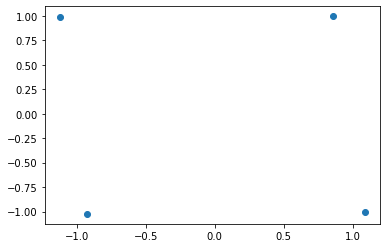

In [4]:
plot_scatter_constellation(encoder1)

In [5]:
encoder1.trainable = False

In [76]:
seed_everything(22)
input_signal2 = Input(shape=(M,), name="input2")
decoder1 = create_decoder([M * 4, M * 2, M], name="decoder1", activation="relu")
decoder2 = create_decoder([M * 4, M * 2, M], name="decoder2", activation="relu")
signal_input2 = create_inputs(R=R, H=H, t=0, k=1, ebno=ebno, name="transmit2")
signal_input1 = create_inputs(R=R, H=H, t=0, k=0, ebno=ebno, name="transmit1")
combiner = create_combiner(layer_sizes=[n_channel * 4, n_channel], activations=["relu", "tanh"], name="combiner")

In [77]:
x1 = encoder1(input_signal1)
x2 = encoder1(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

optim = SGD(momentum=.9)

model.compile(optimizer="rmsprop", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

train_datas = generate_train_datas(k=2)

model.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=40000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="loss", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    AlphaCallback(alpha),
])

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            34          input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 4)            0           encoder1[40][0]           

C:\Users\Furkan\miniconda3\envs\commtf\lib\site-packages\keras\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.391000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200000/200000 [==============================] - 4s 20us/step - loss: 1.4602 - decoder1_loss: 1.3497 - decoder2_loss: 1.5587 - decoder1_acc: 0.3634 - decoder1_BER: 0.2500 - decoder2_acc: 0.1519 - decoder2_BER: 0.2500 - val_loss: 1.4290 - val_decoder1_loss: 1.3288 - val_decoder2_loss: 1.5165 - val_decoder1_acc: 0.3756 - val_decoder1_BER: 0.2500 - val_decoder2_acc: 0.2101 - val_decoder2_BER: 0.2500
Epoch 2/2000
200000/200000 [==============================] - 1s 3us/step - loss: 1.4127 - decoder1_loss: 1.3198 - decoder2_loss: 1.4945 - decoder1_acc: 0.4123 - decoder1_BER: 0.2500 - decoder2_acc: 0.2810 - decoder2_BER: 0.2500 - val_loss: 1.3913 - val_decoder1_loss: 1.3063 - val_decoder2_loss: 1.4669 - val_decoder1_acc: 0.4587 - val_decoder1_BER: 0.2500 - val_decoder2_acc: 0.3731 - val_decoder2_BER: 0.2500
Epoch 3/2000
200000/200000 [==============================] - 1s 3us/step - loss: 1.3782 - decoder1_loss: 1.2987 - decoder2_loss: 1.4493 - decoder1_acc: 0.4635 - decoder1_BER: 0.2500 - dec

Epoch 21/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.0000 - decoder1_loss: 1.0097 - decoder2_loss: 0.9900 - decoder1_acc: 0.5504 - decoder1_BER: 0.1903 - decoder2_acc: 0.5259 - decoder2_BER: 0.2102 - val_loss: 0.9984 - val_decoder1_loss: 1.0052 - val_decoder2_loss: 0.9915 - val_decoder1_acc: 0.5487 - val_decoder1_BER: 0.1890 - val_decoder2_acc: 0.5245 - val_decoder2_BER: 0.2107
Epoch 22/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.9854 - decoder1_loss: 0.9955 - decoder2_loss: 0.9751 - decoder1_acc: 0.5529 - decoder1_BER: 0.1848 - decoder2_acc: 0.5313 - decoder2_BER: 0.2100 - val_loss: 0.9842 - val_decoder1_loss: 0.9905 - val_decoder2_loss: 0.9779 - val_decoder1_acc: 0.5552 - val_decoder1_BER: 0.1842 - val_decoder2_acc: 0.5275 - val_decoder2_BER: 0.2105
Epoch 23/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.9707 - decoder1_loss: 0.9810 - decoder2_loss: 0.9602 - decoder1_acc: 0.5562 - decoder1_BE

Epoch 41/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.7269 - decoder1_loss: 0.6745 - decoder2_loss: 0.7728 - decoder1_acc: 0.7669 - decoder1_BER: 0.1281 - decoder2_acc: 0.5646 - decoder2_BER: 0.2082 - val_loss: 0.7536 - val_decoder1_loss: 0.7102 - val_decoder2_loss: 0.7910 - val_decoder1_acc: 0.7739 - val_decoder1_BER: 0.1197 - val_decoder2_acc: 0.5526 - val_decoder2_BER: 0.2105
Epoch 42/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.7160 - decoder1_loss: 0.6598 - decoder2_loss: 0.7645 - decoder1_acc: 0.7731 - decoder1_BER: 0.1233 - decoder2_acc: 0.5699 - decoder2_BER: 0.2083 - val_loss: 0.7415 - val_decoder1_loss: 0.6920 - val_decoder2_loss: 0.7843 - val_decoder1_acc: 0.7822 - val_decoder1_BER: 0.1146 - val_decoder2_acc: 0.5580 - val_decoder2_BER: 0.2109
Epoch 43/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.7054 - decoder1_loss: 0.6443 - decoder2_loss: 0.7576 - decoder1_acc: 0.7833 - decoder1_BE

Epoch 61/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.5475 - decoder1_loss: 0.4368 - decoder2_loss: 0.6252 - decoder1_acc: 0.8717 - decoder1_BER: 0.0773 - decoder2_acc: 0.6703 - decoder2_BER: 0.1686 - val_loss: 0.5967 - val_decoder1_loss: 0.4889 - val_decoder2_loss: 0.6715 - val_decoder1_acc: 0.8258 - val_decoder1_BER: 0.0953 - val_decoder2_acc: 0.6127 - val_decoder2_BER: 0.1931
Epoch 62/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.5405 - decoder1_loss: 0.4288 - decoder2_loss: 0.6180 - decoder1_acc: 0.8714 - decoder1_BER: 0.0755 - decoder2_acc: 0.6756 - decoder2_BER: 0.1645 - val_loss: 0.5956 - val_decoder1_loss: 0.4826 - val_decoder2_loss: 0.6738 - val_decoder1_acc: 0.8257 - val_decoder1_BER: 0.0929 - val_decoder2_acc: 0.6075 - val_decoder2_BER: 0.1951
Epoch 63/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.5338 - decoder1_loss: 0.4212 - decoder2_loss: 0.6114 - decoder1_acc: 0.8742 - decoder1_BE

Epoch 81/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.4375 - decoder1_loss: 0.3279 - decoder2_loss: 0.5081 - decoder1_acc: 0.8783 - decoder1_BER: 0.0611 - decoder2_acc: 0.7072 - decoder2_BER: 0.1441 - val_loss: 0.5165 - val_decoder1_loss: 0.3753 - val_decoder2_loss: 0.6069 - val_decoder1_acc: 0.8469 - val_decoder1_BER: 0.0765 - val_decoder2_acc: 0.6544 - val_decoder2_BER: 0.1688
Epoch 82/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.4341 - decoder1_loss: 0.3242 - decoder2_loss: 0.5045 - decoder1_acc: 0.8786 - decoder1_BER: 0.0610 - decoder2_acc: 0.7078 - decoder2_BER: 0.1439 - val_loss: 0.5163 - val_decoder1_loss: 0.3727 - val_decoder2_loss: 0.6095 - val_decoder1_acc: 0.8484 - val_decoder1_BER: 0.0758 - val_decoder2_acc: 0.6553 - val_decoder2_BER: 0.1679
Epoch 83/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.4303 - decoder1_loss: 0.3214 - decoder2_loss: 0.5002 - decoder1_acc: 0.8797 - decoder1_BE

Epoch 101/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3890 - decoder1_loss: 0.2933 - decoder2_loss: 0.4515 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.7544 - decoder2_BER: 0.1236 - val_loss: 0.4848 - val_decoder1_loss: 0.3579 - val_decoder2_loss: 0.5654 - val_decoder1_acc: 0.8467 - val_decoder1_BER: 0.0766 - val_decoder2_acc: 0.7147 - val_decoder2_BER: 0.1449
Epoch 102/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3876 - decoder1_loss: 0.2944 - decoder2_loss: 0.4480 - decoder1_acc: 0.8821 - decoder1_BER: 0.0589 - decoder2_acc: 0.7605 - decoder2_BER: 0.1212 - val_loss: 0.4845 - val_decoder1_loss: 0.3560 - val_decoder2_loss: 0.5716 - val_decoder1_acc: 0.8471 - val_decoder1_BER: 0.0764 - val_decoder2_acc: 0.7185 - val_decoder2_BER: 0.1433
Epoch 103/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3867 - decoder1_loss: 0.2951 - decoder2_loss: 0.4474 - decoder1_acc: 0.8814 - decoder1

Epoch 121/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.3407 - decoder1_loss: 0.2903 - decoder2_loss: 0.3792 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8529 - decoder2_BER: 0.0737 - val_loss: 0.4495 - val_decoder1_loss: 0.3561 - val_decoder2_loss: 0.5220 - val_decoder1_acc: 0.8480 - val_decoder1_BER: 0.0760 - val_decoder2_acc: 0.7858 - val_decoder2_BER: 0.1072
Epoch 122/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3353 - decoder1_loss: 0.2900 - decoder2_loss: 0.3706 - decoder1_acc: 0.8816 - decoder1_BER: 0.0592 - decoder2_acc: 0.8573 - decoder2_BER: 0.0714 - val_loss: 0.4524 - val_decoder1_loss: 0.3485 - val_decoder2_loss: 0.5351 - val_decoder1_acc: 0.8511 - val_decoder1_BER: 0.0745 - val_decoder2_acc: 0.7785 - val_decoder2_BER: 0.1110
Epoch 123/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.3351 - decoder1_loss: 0.2901 - decoder2_loss: 0.3706 - decoder1_acc: 0.8816 - decoder1

Epoch 141/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.3025 - decoder1_loss: 0.2872 - decoder2_loss: 0.3166 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8747 - decoder2_BER: 0.0627 - val_loss: 0.3267 - val_decoder1_loss: 0.2969 - val_decoder2_loss: 0.3529 - val_decoder1_acc: 0.8768 - val_decoder1_BER: 0.0616 - val_decoder2_acc: 0.8523 - val_decoder2_BER: 0.0738
Epoch 142/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3010 - decoder1_loss: 0.2876 - decoder2_loss: 0.3130 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8756 - decoder2_BER: 0.0622 - val_loss: 0.3187 - val_decoder1_loss: 0.2918 - val_decoder2_loss: 0.3440 - val_decoder1_acc: 0.8795 - val_decoder1_BER: 0.0602 - val_decoder2_acc: 0.8562 - val_decoder2_BER: 0.0720
Epoch 143/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3012 - decoder1_loss: 0.2868 - decoder2_loss: 0.3144 - decoder1_acc: 0.8827 - decoder1

Epoch 161/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2909 - decoder1_loss: 0.2865 - decoder2_loss: 0.2954 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8799 - decoder2_BER: 0.0601 - val_loss: 0.2957 - val_decoder1_loss: 0.2895 - val_decoder2_loss: 0.3015 - val_decoder1_acc: 0.8814 - val_decoder1_BER: 0.0593 - val_decoder2_acc: 0.8768 - val_decoder2_BER: 0.0616
Epoch 162/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2918 - decoder1_loss: 0.2894 - decoder2_loss: 0.2941 - decoder1_acc: 0.8819 - decoder1_BER: 0.0590 - decoder2_acc: 0.8800 - decoder2_BER: 0.0600 - val_loss: 0.2942 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.3026 - val_decoder1_acc: 0.8825 - val_decoder1_BER: 0.0587 - val_decoder2_acc: 0.8755 - val_decoder2_BER: 0.0622
Epoch 163/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2916 - decoder1_loss: 0.2890 - decoder2_loss: 0.2943 - decoder1_acc: 0.8818 - decoder1

Epoch 181/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2907 - decoder1_loss: 0.2906 - decoder2_loss: 0.2907 - decoder1_acc: 0.8818 - decoder1_BER: 0.0591 - decoder2_acc: 0.8819 - decoder2_BER: 0.0591 - val_loss: 0.2903 - val_decoder1_loss: 0.2812 - val_decoder2_loss: 0.2996 - val_decoder1_acc: 0.8847 - val_decoder1_BER: 0.0577 - val_decoder2_acc: 0.8774 - val_decoder2_BER: 0.0613
Epoch 182/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2908 - decoder1_loss: 0.2906 - decoder2_loss: 0.2910 - decoder1_acc: 0.8812 - decoder1_BER: 0.0594 - decoder2_acc: 0.8816 - decoder2_BER: 0.0592 - val_loss: 0.2880 - val_decoder1_loss: 0.2802 - val_decoder2_loss: 0.2959 - val_decoder1_acc: 0.8859 - val_decoder1_BER: 0.0570 - val_decoder2_acc: 0.8784 - val_decoder2_BER: 0.0608
Epoch 183/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2883 - decoder1_loss: 0.2886 - decoder2_loss: 0.2881 - decoder1_acc: 0.8827 - decoder1

Epoch 201/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2917 - decoder1_loss: 0.2935 - decoder2_loss: 0.2899 - decoder1_acc: 0.8806 - decoder1_BER: 0.0597 - decoder2_acc: 0.8814 - decoder2_BER: 0.0593 - val_loss: 0.2877 - val_decoder1_loss: 0.2805 - val_decoder2_loss: 0.2949 - val_decoder1_acc: 0.8859 - val_decoder1_BER: 0.0570 - val_decoder2_acc: 0.8792 - val_decoder2_BER: 0.0604
Epoch 202/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2886 - decoder1_loss: 0.2882 - decoder2_loss: 0.2890 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8818 - decoder2_BER: 0.0591 - val_loss: 0.2874 - val_decoder1_loss: 0.2813 - val_decoder2_loss: 0.2936 - val_decoder1_acc: 0.8847 - val_decoder1_BER: 0.0577 - val_decoder2_acc: 0.8800 - val_decoder2_BER: 0.0600
Epoch 203/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2890 - decoder1_loss: 0.2873 - decoder2_loss: 0.2908 - decoder1_acc: 0.8830 - decoder1

Epoch 221/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2882 - decoder2_loss: 0.2900 - decoder1_acc: 0.8818 - decoder1_BER: 0.0591 - decoder2_acc: 0.8823 - decoder2_BER: 0.0588 - val_loss: 0.2865 - val_decoder1_loss: 0.2804 - val_decoder2_loss: 0.2926 - val_decoder1_acc: 0.8855 - val_decoder1_BER: 0.0572 - val_decoder2_acc: 0.8806 - val_decoder2_BER: 0.0597
Epoch 222/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2883 - decoder1_loss: 0.2891 - decoder2_loss: 0.2874 - decoder1_acc: 0.8812 - decoder1_BER: 0.0594 - decoder2_acc: 0.8823 - decoder2_BER: 0.0588 - val_loss: 0.2873 - val_decoder1_loss: 0.2826 - val_decoder2_loss: 0.2919 - val_decoder1_acc: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_acc: 0.8806 - val_decoder2_BER: 0.0597
Epoch 223/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2882 - decoder1_loss: 0.2880 - decoder2_loss: 0.2883 - decoder1_acc: 0.8820 - decoder1

Epoch 241/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2896 - decoder1_loss: 0.2903 - decoder2_loss: 0.2888 - decoder1_acc: 0.8821 - decoder1_BER: 0.0589 - decoder2_acc: 0.8821 - decoder2_BER: 0.0590 - val_loss: 0.2871 - val_decoder1_loss: 0.2825 - val_decoder2_loss: 0.2917 - val_decoder1_acc: 0.8851 - val_decoder1_BER: 0.0575 - val_decoder2_acc: 0.8803 - val_decoder2_BER: 0.0598
Epoch 242/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2889 - decoder2_loss: 0.2893 - decoder1_acc: 0.8819 - decoder1_BER: 0.0591 - decoder2_acc: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.2873 - val_decoder1_loss: 0.2811 - val_decoder2_loss: 0.2935 - val_decoder1_acc: 0.8849 - val_decoder1_BER: 0.0575 - val_decoder2_acc: 0.8797 - val_decoder2_BER: 0.0602
Epoch 243/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2884 - decoder1_loss: 0.2897 - decoder2_loss: 0.2871 - decoder1_acc: 0.8812 - decoder1

Epoch 261/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2884 - decoder1_loss: 0.2882 - decoder2_loss: 0.2885 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8827 - decoder2_BER: 0.0587 - val_loss: 0.2880 - val_decoder1_loss: 0.2806 - val_decoder2_loss: 0.2955 - val_decoder1_acc: 0.8861 - val_decoder1_BER: 0.0569 - val_decoder2_acc: 0.8798 - val_decoder2_BER: 0.0601
Epoch 262/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2886 - decoder2_loss: 0.2896 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2870 - val_decoder1_loss: 0.2831 - val_decoder2_loss: 0.2909 - val_decoder1_acc: 0.8846 - val_decoder1_BER: 0.0577 - val_decoder2_acc: 0.8816 - val_decoder2_BER: 0.0592
Epoch 263/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2895 - decoder1_loss: 0.2899 - decoder2_loss: 0.2891 - decoder1_acc: 0.8818 - decoder1

Epoch 281/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2907 - decoder2_loss: 0.2876 - decoder1_acc: 0.8809 - decoder1_BER: 0.0595 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2878 - val_decoder1_loss: 0.2827 - val_decoder2_loss: 0.2930 - val_decoder1_acc: 0.8852 - val_decoder1_BER: 0.0574 - val_decoder2_acc: 0.8800 - val_decoder2_BER: 0.0600
Epoch 282/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2887 - decoder1_loss: 0.2895 - decoder2_loss: 0.2880 - decoder1_acc: 0.8821 - decoder1_BER: 0.0589 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2889 - val_decoder1_loss: 0.2831 - val_decoder2_loss: 0.2948 - val_decoder1_acc: 0.8849 - val_decoder1_BER: 0.0575 - val_decoder2_acc: 0.8794 - val_decoder2_BER: 0.0603
Epoch 283/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2895 - decoder1_loss: 0.2913 - decoder2_loss: 0.2876 - decoder1_acc: 0.8811 - decoder1

Epoch 301/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2873 - decoder1_loss: 0.2879 - decoder2_loss: 0.2867 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2880 - val_decoder1_loss: 0.2842 - val_decoder2_loss: 0.2920 - val_decoder1_acc: 0.8848 - val_decoder1_BER: 0.0576 - val_decoder2_acc: 0.8806 - val_decoder2_BER: 0.0597
Epoch 302/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2893 - decoder1_loss: 0.2903 - decoder2_loss: 0.2883 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2891 - val_decoder1_loss: 0.2836 - val_decoder2_loss: 0.2947 - val_decoder1_acc: 0.8843 - val_decoder1_BER: 0.0578 - val_decoder2_acc: 0.8793 - val_decoder2_BER: 0.0603
Epoch 303/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2902 - decoder1_loss: 0.2912 - decoder2_loss: 0.2892 - decoder1_acc: 0.8804 - decoder1

Epoch 321/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2897 - decoder1_loss: 0.2885 - decoder2_loss: 0.2910 - decoder1_acc: 0.8817 - decoder1_BER: 0.0591 - decoder2_acc: 0.8811 - decoder2_BER: 0.0595 - val_loss: 0.2911 - val_decoder1_loss: 0.2855 - val_decoder2_loss: 0.2966 - val_decoder1_acc: 0.8839 - val_decoder1_BER: 0.0581 - val_decoder2_acc: 0.8784 - val_decoder2_BER: 0.0608
Epoch 322/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2877 - decoder1_loss: 0.2887 - decoder2_loss: 0.2868 - decoder1_acc: 0.8819 - decoder1_BER: 0.0590 - decoder2_acc: 0.8830 - decoder2_BER: 0.0585 - val_loss: 0.2885 - val_decoder1_loss: 0.2829 - val_decoder2_loss: 0.2942 - val_decoder1_acc: 0.8844 - val_decoder1_BER: 0.0578 - val_decoder2_acc: 0.8800 - val_decoder2_BER: 0.0600
Epoch 323/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2904 - decoder1_loss: 0.2896 - decoder2_loss: 0.2912 - decoder1_acc: 0.8813 - decoder1

Epoch 341/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2880 - decoder1_loss: 0.2882 - decoder2_loss: 0.2879 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2900 - val_decoder1_loss: 0.2853 - val_decoder2_loss: 0.2947 - val_decoder1_acc: 0.8833 - val_decoder1_BER: 0.0584 - val_decoder2_acc: 0.8790 - val_decoder2_BER: 0.0605
Epoch 342/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2874 - decoder1_loss: 0.2890 - decoder2_loss: 0.2858 - decoder1_acc: 0.8824 - decoder1_BER: 0.0588 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.2905 - val_decoder1_loss: 0.2854 - val_decoder2_loss: 0.2958 - val_decoder1_acc: 0.8837 - val_decoder1_BER: 0.0582 - val_decoder2_acc: 0.8791 - val_decoder2_BER: 0.0604
Epoch 343/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2893 - decoder1_loss: 0.2902 - decoder2_loss: 0.2884 - decoder1_acc: 0.8819 - decoder1

Epoch 361/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2890 - decoder1_loss: 0.2890 - decoder2_loss: 0.2891 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2905 - val_decoder1_loss: 0.2831 - val_decoder2_loss: 0.2979 - val_decoder1_acc: 0.8848 - val_decoder1_BER: 0.0576 - val_decoder2_acc: 0.8785 - val_decoder2_BER: 0.0607
Epoch 362/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2881 - decoder1_loss: 0.2894 - decoder2_loss: 0.2868 - decoder1_acc: 0.8808 - decoder1_BER: 0.0596 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2890 - val_decoder1_loss: 0.2839 - val_decoder2_loss: 0.2942 - val_decoder1_acc: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_acc: 0.8789 - val_decoder2_BER: 0.0605
Epoch 363/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2888 - decoder1_loss: 0.2887 - decoder2_loss: 0.2888 - decoder1_acc: 0.8818 - decoder1

Epoch 381/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2877 - decoder1_loss: 0.2872 - decoder2_loss: 0.2882 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.2900 - val_decoder1_loss: 0.2847 - val_decoder2_loss: 0.2953 - val_decoder1_acc: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_acc: 0.8790 - val_decoder2_BER: 0.0605
Epoch 382/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2880 - decoder1_loss: 0.2890 - decoder2_loss: 0.2869 - decoder1_acc: 0.8816 - decoder1_BER: 0.0592 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2891 - val_decoder1_loss: 0.2843 - val_decoder2_loss: 0.2941 - val_decoder1_acc: 0.8841 - val_decoder1_BER: 0.0580 - val_decoder2_acc: 0.8802 - val_decoder2_BER: 0.0599
Epoch 383/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2889 - decoder1_loss: 0.2893 - decoder2_loss: 0.2885 - decoder1_acc: 0.8820 - decoder1

Epoch 401/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2895 - decoder2_loss: 0.2887 - decoder1_acc: 0.8821 - decoder1_BER: 0.0590 - decoder2_acc: 0.8825 - decoder2_BER: 0.0588 - val_loss: 0.2894 - val_decoder1_loss: 0.2851 - val_decoder2_loss: 0.2936 - val_decoder1_acc: 0.8831 - val_decoder1_BER: 0.0584 - val_decoder2_acc: 0.8790 - val_decoder2_BER: 0.0605
Epoch 402/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2879 - decoder1_loss: 0.2872 - decoder2_loss: 0.2885 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2899 - val_decoder1_loss: 0.2863 - val_decoder2_loss: 0.2935 - val_decoder1_acc: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_acc: 0.8801 - val_decoder2_BER: 0.0599
Epoch 403/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2876 - decoder1_loss: 0.2876 - decoder2_loss: 0.2876 - decoder1_acc: 0.8818 - decoder1

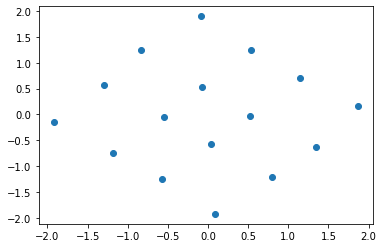

In [78]:
hebe = plot_scatter_duo([encoder1, encoder1], combiner, show=True)
# print(hebe)

In [41]:
hube = np.array(hebe)
sig = np.array(hube[:, 0] + 1j * hube[:, 1])
sig_power = np.sum(np.abs(sig**2)) / len(sig)
sig_power

1.985748052597046

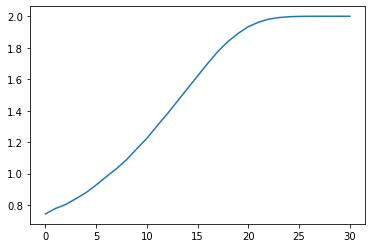

In [21]:
SNR_range = np.arange(0, 31, 1) - 10
ebno_range1 = calc_ebno(SNR_range)
ebno_range2 = calc_ebno(SNR_range)
ber1, ber2 = [], []
test_data_1 = generate_data(M=M)
test_data_2 = generate_data(M=M)
for i in range(len(SNR_range)):
    ebno1 = ebno_range1[i]
    ebno2 = ebno_range2[i]
    out1 = encoder1.predict(test_data_1)
    out2 = encoder1.predict(test_data_2)
    concatenated = np.concatenate([out1, out2], axis=1)
    out = combiner.predict(concatenated)
    noise1 = np.sqrt(1 / (2 * R * ebno1)) * np.random.randn(*out.shape)
    noise2 = np.sqrt(1 / (2 * R * ebno2)) * np.random.randn(*out.shape)
    out1 = decoder1.predict(out + noise1)
    out2 = decoder2.predict(out + noise2)

    pred1 = np.argmax(out1, axis=1)
    pred2 = np.argmax(out2, axis=1)

    errors1 = np.asarray((pred1 != np.argmax(test_data_1, axis=1))).astype(int).mean()
    errors2 = np.asarray((pred2 != np.argmax(test_data_2, axis=1))).astype(int).mean()

    ber1.append(errors1)
    ber2.append(errors2)

rates = (1 - np.array(ber1)) * R + (1 - np.array(ber2)) * R
plt.plot(rates)

In [19]:
rates = rate_curve(bers)

30

In [5]:
def experiment(seed):
    seed_everything(seed)
    input_signal1 = Input(shape=(M,), name="input1")
    input_signal2 = Input(shape=(M,), name="input2")
    encoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder1")
    encoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder2")

    combiner = Sequential([
        Dense(n_channel, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="combiner")

    signal_input1 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1")

    signal_input2 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

    decoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder1")

    decoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder2")
    x1 = encoder1(input_signal1)
    x1 = signal_input1(x1)
    out1 = decoder1(x1)

    model1 = Model(inputs=input_signal1, outputs=out1)
    alpha = K.variable(.5)

    model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", BER])
    train_datas = generate_train_datas(k=1)

    model1.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
        epochs=2000, callbacks=[
        EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
        ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    ])
    
    bers = ber_curve(encoder1, decoder1, R = R, SNR_range = [-10, 20], M=M)
    
    return rate_curve([bers], R=R)

In [7]:
file_name = "rates.txt"
for seed in range(50):
    rate = experiment(seed)
    with open(file_name, "a+") as f:
        f.write("{} seed - rate {}\n\n".format(seed, rate))

================] - 0s 2us/step - loss: 0.0046 - accuracy: 0.9984 - BER: 7.8750e-04 - val_loss: 9.0752e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 191/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0045 - accuracy: 0.9986 - BER: 7.0000e-04 - val_loss: 8.9063e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 192/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0051 - accuracy: 0.9983 - BER: 8.5250e-04 - val_loss: 8.7940e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 193/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0049 - accuracy: 0.9985 - BER: 7.5625e-04 - val_loss: 8.6259e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 194/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0053 - accuracy: 0.9982 - BER: 8.7500e-04 - val_loss: 8.4533e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 195/2000
200000/200000 [==============================] - 

KeyboardInterrupt: 

In [29]:
hebe

NameError: name 'hebe' is not defined

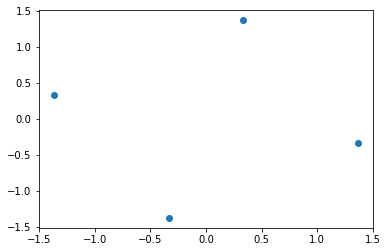

In [41]:
plot_scatter_constellation(encoder1)

# Experiment 3

In [6]:
train_data_1, label_data_1 = generate_qam()
train_data_2, label_data_2 = generate_qam()

In [7]:
input_signal1 = Input(shape=(2,), name="input1")
input_signal2 = Input(shape=(2,), name="input2")

decoder1 = create_decoder([M * 4, M * 2, M], name="decoder1", activation="relu")
decoder2 = create_decoder([M * 4, M * 2, M], name="decoder2", activation="relu")
signal_input2 = create_inputs(R=R, H=H, t=0, k=1, ebno=ebno, name="transmit2")
signal_input1 = create_inputs(R=R, H=H, t=0, k=0, ebno=ebno, name="transmit1")
combiner = create_combiner(layer_sizes=[n_channel * 4, n_channel], activations=["relu", "tanh"], name="combiner")

In [8]:
x = concatenate([input_signal1, input_signal2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

model.compile(optimizer="adam", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 2)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 4)            0           input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
combiner (Sequential)           (None, 2)            62          concatenate_2[0][0]        

In [10]:
model.fit(x=[train_data_1, train_data_2], y=[label_data_1, label_data_2], validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
])


Train on 50000 samples, validate on 50000 samples
Epoch 1/2000
50000/50000 [==============================] - 1s 21us/step - loss: 1.4998 - decoder1_loss: 1.5530 - decoder2_loss: 1.4466 - decoder1_accuracy: 0.2332 - decoder1_BER: 0.2981 - decoder2_accuracy: 0.2276 - decoder2_BER: 0.2500 - val_loss: 1.4146 - val_decoder1_loss: 1.4290 - val_decoder2_loss: 1.4001 - val_decoder1_accuracy: 0.2246 - val_decoder1_BER: 0.2529 - val_decoder2_accuracy: 0.2230 - val_decoder2_BER: 0.2500
Epoch 2/2000
40000/50000 [=======================>......] - ETA: 0s - loss: 1.4675 - decoder1_loss: 1.5085 - decoder2_loss: 1.4266 - decoder1_accuracy: 0.2290 - decoder1_BER: 0.2899 - decoder2_accuracy: 0.2366 - decoder2_BER: 0.2500

/home/furkankucuk/miniconda3/envs/commtf/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `BER` which is not available. Available metrics are: val_loss,val_decoder1_loss,val_decoder2_loss,val_decoder1_accuracy,val_decoder1_BER,val_decoder2_accuracy,val_decoder2_BER,loss,decoder1_loss,decoder2_loss,decoder1_accuracy,decoder1_BER,decoder2_accuracy,decoder2_BER
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 0s 4us/step - loss: 1.4644 - decoder1_loss: 1.5044 - decoder2_loss: 1.4244 - decoder1_accuracy: 0.2274 - decoder1_BER: 0.2888 - decoder2_accuracy: 0.2377 - decoder2_BER: 0.2500 - val_loss: 1.4009 - val_decoder1_loss: 1.4114 - val_decoder2_loss: 1.3905 - val_decoder1_accuracy: 0.2124 - val_decoder1_BER: 0.2507 - val_decoder2_accuracy: 0.2421 - val_decoder2_BER: 0.2500
Epoch 3/2000
50000/50000 [==============================] - 0s 4us/step - loss: 1.4326 - decoder1_loss: 1.4621 - decoder2_loss: 1.4032 - decoder1_accuracy: 0.2282 - decoder1_BER: 0.2778 - decoder2_accuracy: 0.2502 - decoder2_BER: 0.2500 - val_loss: 1.3885 - val_decoder1_loss: 1.3949 - val_decoder2_loss: 1.3821 - val_decoder1_accuracy: 0.2171 - val_decoder1_BER: 0.2501 - val_decoder2_accuracy: 0.2635 - val_decoder2_BER: 0.2500
Epoch 4/2000
50000/50000 [==============================] - 0s 4us/step - loss: 1.4033 - decoder1_loss: 1.4226 - decoder2_loss: 1.3841 - decoder1_accurac

50000/50000 [==============================] - 0s 4us/step - loss: 1.0566 - decoder1_loss: 0.9857 - decoder2_loss: 1.1275 - decoder1_accuracy: 0.7596 - decoder1_BER: 0.1940 - decoder2_accuracy: 0.5078 - decoder2_BER: 0.2464 - val_loss: 1.1169 - val_decoder1_loss: 1.0625 - val_decoder2_loss: 1.1714 - val_decoder1_accuracy: 0.7043 - val_decoder1_BER: 0.2105 - val_decoder2_accuracy: 0.4796 - val_decoder2_BER: 0.2499
Epoch 22/2000
50000/50000 [==============================] - 0s 4us/step - loss: 1.0382 - decoder1_loss: 0.9634 - decoder2_loss: 1.1129 - decoder1_accuracy: 0.7667 - decoder1_BER: 0.1922 - decoder2_accuracy: 0.5129 - decoder2_BER: 0.2462 - val_loss: 1.0988 - val_decoder1_loss: 1.0396 - val_decoder2_loss: 1.1580 - val_decoder1_accuracy: 0.7138 - val_decoder1_BER: 0.2054 - val_decoder2_accuracy: 0.4822 - val_decoder2_BER: 0.2498
Epoch 23/2000
50000/50000 [==============================] - 0s 4us/step - loss: 1.0208 - decoder1_loss: 0.9419 - decoder2_loss: 1.0996 - decoder1_accur

50000/50000 [==============================] - 0s 4us/step - loss: 0.7708 - decoder1_loss: 0.6280 - decoder2_loss: 0.9136 - decoder1_accuracy: 0.8095 - decoder1_BER: 0.1002 - decoder2_accuracy: 0.5036 - decoder2_BER: 0.2437 - val_loss: 0.8382 - val_decoder1_loss: 0.7067 - val_decoder2_loss: 0.9697 - val_decoder1_accuracy: 0.7730 - val_decoder1_BER: 0.1341 - val_decoder2_accuracy: 0.4745 - val_decoder2_BER: 0.2434
Epoch 41/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.7595 - decoder1_loss: 0.6144 - decoder2_loss: 0.9046 - decoder1_accuracy: 0.8118 - decoder1_BER: 0.0976 - decoder2_accuracy: 0.5039 - decoder2_BER: 0.2446 - val_loss: 0.8273 - val_decoder1_loss: 0.6948 - val_decoder2_loss: 0.9597 - val_decoder1_accuracy: 0.7744 - val_decoder1_BER: 0.1304 - val_decoder2_accuracy: 0.4792 - val_decoder2_BER: 0.2428
Epoch 42/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.7480 - decoder1_loss: 0.6009 - decoder2_loss: 0.8950 - decoder1_accur

50000/50000 [==============================] - 0s 4us/step - loss: 0.6102 - decoder1_loss: 0.4435 - decoder2_loss: 0.7768 - decoder1_accuracy: 0.8603 - decoder1_BER: 0.0817 - decoder2_accuracy: 0.5494 - decoder2_BER: 0.2253 - val_loss: 0.7016 - val_decoder1_loss: 0.5531 - val_decoder2_loss: 0.8502 - val_decoder1_accuracy: 0.8151 - val_decoder1_BER: 0.1055 - val_decoder2_accuracy: 0.5144 - val_decoder2_BER: 0.2345
Epoch 60/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.6032 - decoder1_loss: 0.4357 - decoder2_loss: 0.7707 - decoder1_accuracy: 0.8638 - decoder1_BER: 0.0787 - decoder2_accuracy: 0.5575 - decoder2_BER: 0.2232 - val_loss: 0.6991 - val_decoder1_loss: 0.5512 - val_decoder2_loss: 0.8471 - val_decoder1_accuracy: 0.8154 - val_decoder1_BER: 0.1041 - val_decoder2_accuracy: 0.5154 - val_decoder2_BER: 0.2340
Epoch 61/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.5969 - decoder1_loss: 0.4274 - decoder2_loss: 0.7665 - decoder1_accur

50000/50000 [==============================] - 0s 4us/step - loss: 0.5230 - decoder1_loss: 0.3397 - decoder2_loss: 0.7064 - decoder1_accuracy: 0.9018 - decoder1_BER: 0.0533 - decoder2_accuracy: 0.6107 - decoder2_BER: 0.1948 - val_loss: 0.6259 - val_decoder1_loss: 0.4765 - val_decoder2_loss: 0.7753 - val_decoder1_accuracy: 0.8315 - val_decoder1_BER: 0.0850 - val_decoder2_accuracy: 0.5743 - val_decoder2_BER: 0.2103
Epoch 79/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.5201 - decoder1_loss: 0.3348 - decoder2_loss: 0.7053 - decoder1_accuracy: 0.9022 - decoder1_BER: 0.0518 - decoder2_accuracy: 0.6117 - decoder2_BER: 0.1960 - val_loss: 0.6212 - val_decoder1_loss: 0.4693 - val_decoder2_loss: 0.7731 - val_decoder1_accuracy: 0.8364 - val_decoder1_BER: 0.0825 - val_decoder2_accuracy: 0.5759 - val_decoder2_BER: 0.2096
Epoch 80/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.5178 - decoder1_loss: 0.3318 - decoder2_loss: 0.7039 - decoder1_accur

50000/50000 [==============================] - 0s 4us/step - loss: 0.4735 - decoder1_loss: 0.2835 - decoder2_loss: 0.6634 - decoder1_accuracy: 0.9068 - decoder1_BER: 0.0466 - decoder2_accuracy: 0.6429 - decoder2_BER: 0.1807 - val_loss: 0.5160 - val_decoder1_loss: 0.3457 - val_decoder2_loss: 0.6862 - val_decoder1_accuracy: 0.8758 - val_decoder1_BER: 0.0619 - val_decoder2_accuracy: 0.6285 - val_decoder2_BER: 0.1865
Epoch 98/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.4698 - decoder1_loss: 0.2782 - decoder2_loss: 0.6613 - decoder1_accuracy: 0.9095 - decoder1_BER: 0.0453 - decoder2_accuracy: 0.6441 - decoder2_BER: 0.1804 - val_loss: 0.5103 - val_decoder1_loss: 0.3373 - val_decoder2_loss: 0.6832 - val_decoder1_accuracy: 0.8803 - val_decoder1_BER: 0.0597 - val_decoder2_accuracy: 0.6290 - val_decoder2_BER: 0.1865
Epoch 99/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.4673 - decoder1_loss: 0.2754 - decoder2_loss: 0.6593 - decoder1_accur

50000/50000 [==============================] - 0s 4us/step - loss: 0.4183 - decoder1_loss: 0.2667 - decoder2_loss: 0.5699 - decoder1_accuracy: 0.9034 - decoder1_BER: 0.0485 - decoder2_accuracy: 0.7004 - decoder2_BER: 0.1493 - val_loss: 0.4826 - val_decoder1_loss: 0.3109 - val_decoder2_loss: 0.6542 - val_decoder1_accuracy: 0.8815 - val_decoder1_BER: 0.0594 - val_decoder2_accuracy: 0.6555 - val_decoder2_BER: 0.1691
Epoch 117/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.4178 - decoder1_loss: 0.2710 - decoder2_loss: 0.5647 - decoder1_accuracy: 0.8994 - decoder1_BER: 0.0504 - decoder2_accuracy: 0.7027 - decoder2_BER: 0.1481 - val_loss: 0.4914 - val_decoder1_loss: 0.3176 - val_decoder2_loss: 0.6652 - val_decoder1_accuracy: 0.8772 - val_decoder1_BER: 0.0612 - val_decoder2_accuracy: 0.6485 - val_decoder2_BER: 0.1716
Epoch 118/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.4151 - decoder1_loss: 0.2700 - decoder2_loss: 0.5602 - decoder1_acc

Epoch 135/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.3746 - decoder1_loss: 0.2567 - decoder2_loss: 0.4926 - decoder1_accuracy: 0.9019 - decoder1_BER: 0.0490 - decoder2_accuracy: 0.7469 - decoder2_BER: 0.1265 - val_loss: 0.4547 - val_decoder1_loss: 0.3688 - val_decoder2_loss: 0.5406 - val_decoder1_accuracy: 0.8488 - val_decoder1_BER: 0.0755 - val_decoder2_accuracy: 0.7193 - val_decoder2_BER: 0.1393
Epoch 136/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.3765 - decoder1_loss: 0.2571 - decoder2_loss: 0.4960 - decoder1_accuracy: 0.9013 - decoder1_BER: 0.0493 - decoder2_accuracy: 0.7493 - decoder2_BER: 0.1254 - val_loss: 0.4497 - val_decoder1_loss: 0.3653 - val_decoder2_loss: 0.5341 - val_decoder1_accuracy: 0.8508 - val_decoder1_BER: 0.0746 - val_decoder2_accuracy: 0.7205 - val_decoder2_BER: 0.1388
Epoch 137/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.3751 - decoder1_loss: 0.2588 - decoder2_loss: 0.4915

Epoch 154/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.3390 - decoder1_loss: 0.2510 - decoder2_loss: 0.4270 - decoder1_accuracy: 0.9022 - decoder1_BER: 0.0489 - decoder2_accuracy: 0.8202 - decoder2_BER: 0.0898 - val_loss: 0.4536 - val_decoder1_loss: 0.4504 - val_decoder2_loss: 0.4568 - val_decoder1_accuracy: 0.8151 - val_decoder1_BER: 0.0925 - val_decoder2_accuracy: 0.8075 - val_decoder2_BER: 0.0964
Epoch 155/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.3377 - decoder1_loss: 0.2586 - decoder2_loss: 0.4169 - decoder1_accuracy: 0.8979 - decoder1_BER: 0.0510 - decoder2_accuracy: 0.8260 - decoder2_BER: 0.0872 - val_loss: 0.4565 - val_decoder1_loss: 0.4558 - val_decoder2_loss: 0.4573 - val_decoder1_accuracy: 0.8125 - val_decoder1_BER: 0.0937 - val_decoder2_accuracy: 0.8101 - val_decoder2_BER: 0.0949
Epoch 156/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.3338 - decoder1_loss: 0.2555 - decoder2_loss: 0.4121

Epoch 173/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2993 - decoder1_loss: 0.2771 - decoder2_loss: 0.3214 - decoder1_accuracy: 0.8901 - decoder1_BER: 0.0549 - decoder2_accuracy: 0.8726 - decoder2_BER: 0.0637 - val_loss: 0.3781 - val_decoder1_loss: 0.4028 - val_decoder2_loss: 0.3535 - val_decoder1_accuracy: 0.8347 - val_decoder1_BER: 0.0826 - val_decoder2_accuracy: 0.8574 - val_decoder2_BER: 0.0713
Epoch 174/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2986 - decoder1_loss: 0.2771 - decoder2_loss: 0.3202 - decoder1_accuracy: 0.8890 - decoder1_BER: 0.0555 - decoder2_accuracy: 0.8729 - decoder2_BER: 0.0636 - val_loss: 0.3771 - val_decoder1_loss: 0.4099 - val_decoder2_loss: 0.3443 - val_decoder1_accuracy: 0.8316 - val_decoder1_BER: 0.0842 - val_decoder2_accuracy: 0.8599 - val_decoder2_BER: 0.0701
Epoch 175/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2986 - decoder1_loss: 0.2816 - decoder2_loss: 0.3157

Epoch 192/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2903 - decoder1_loss: 0.2815 - decoder2_loss: 0.2992 - decoder1_accuracy: 0.8862 - decoder1_BER: 0.0569 - decoder2_accuracy: 0.8778 - decoder2_BER: 0.0611 - val_loss: 0.3281 - val_decoder1_loss: 0.3466 - val_decoder2_loss: 0.3096 - val_decoder1_accuracy: 0.8575 - val_decoder1_BER: 0.0713 - val_decoder2_accuracy: 0.8734 - val_decoder2_BER: 0.0633
Epoch 193/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2926 - decoder1_loss: 0.2840 - decoder2_loss: 0.3013 - decoder1_accuracy: 0.8835 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8775 - decoder2_BER: 0.0612 - val_loss: 0.3361 - val_decoder1_loss: 0.3708 - val_decoder2_loss: 0.3014 - val_decoder1_accuracy: 0.8474 - val_decoder1_BER: 0.0763 - val_decoder2_accuracy: 0.8768 - val_decoder2_BER: 0.0616
Epoch 194/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2924 - decoder1_loss: 0.2866 - decoder2_loss: 0.2982

Epoch 211/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2916 - decoder1_loss: 0.2870 - decoder2_loss: 0.2962 - decoder1_accuracy: 0.8838 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8803 - decoder2_BER: 0.0599 - val_loss: 0.2990 - val_decoder1_loss: 0.3082 - val_decoder2_loss: 0.2899 - val_decoder1_accuracy: 0.8744 - val_decoder1_BER: 0.0628 - val_decoder2_accuracy: 0.8831 - val_decoder2_BER: 0.0585
Epoch 212/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2933 - decoder1_loss: 0.2904 - decoder2_loss: 0.2962 - decoder1_accuracy: 0.8821 - decoder1_BER: 0.0589 - decoder2_accuracy: 0.8785 - decoder2_BER: 0.0607 - val_loss: 0.2994 - val_decoder1_loss: 0.3087 - val_decoder2_loss: 0.2902 - val_decoder1_accuracy: 0.8742 - val_decoder1_BER: 0.0629 - val_decoder2_accuracy: 0.8816 - val_decoder2_BER: 0.0592
Epoch 213/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2846 - decoder2_loss: 0.2980

Epoch 230/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2922 - decoder1_loss: 0.2884 - decoder2_loss: 0.2960 - decoder1_accuracy: 0.8819 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8788 - decoder2_BER: 0.0606 - val_loss: 0.2943 - val_decoder1_loss: 0.2940 - val_decoder2_loss: 0.2946 - val_decoder1_accuracy: 0.8816 - val_decoder1_BER: 0.0592 - val_decoder2_accuracy: 0.8802 - val_decoder2_BER: 0.0599
Epoch 231/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2933 - decoder1_loss: 0.2880 - decoder2_loss: 0.2986 - decoder1_accuracy: 0.8841 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8777 - decoder2_BER: 0.0612 - val_loss: 0.2910 - val_decoder1_loss: 0.2948 - val_decoder2_loss: 0.2873 - val_decoder1_accuracy: 0.8788 - val_decoder1_BER: 0.0606 - val_decoder2_accuracy: 0.8826 - val_decoder2_BER: 0.0587
Epoch 232/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2862 - decoder2_loss: 0.2963

Epoch 249/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2903 - decoder1_loss: 0.2852 - decoder2_loss: 0.2953 - decoder1_accuracy: 0.8842 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8786 - decoder2_BER: 0.0608 - val_loss: 0.2882 - val_decoder1_loss: 0.2864 - val_decoder2_loss: 0.2900 - val_decoder1_accuracy: 0.8834 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8812 - val_decoder2_BER: 0.0594
Epoch 250/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2893 - decoder2_loss: 0.2918 - decoder1_accuracy: 0.8826 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.2854 - val_decoder1_loss: 0.2824 - val_decoder2_loss: 0.2884 - val_decoder1_accuracy: 0.8862 - val_decoder1_BER: 0.0569 - val_decoder2_accuracy: 0.8819 - val_decoder2_BER: 0.0591
Epoch 251/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2884 - decoder1_loss: 0.2846 - decoder2_loss: 0.2922

Epoch 268/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2887 - decoder1_loss: 0.2873 - decoder2_loss: 0.2902 - decoder1_accuracy: 0.8831 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2831 - val_decoder1_loss: 0.2796 - val_decoder2_loss: 0.2866 - val_decoder1_accuracy: 0.8880 - val_decoder1_BER: 0.0560 - val_decoder2_accuracy: 0.8823 - val_decoder2_BER: 0.0589
Epoch 269/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2889 - decoder1_loss: 0.2885 - decoder2_loss: 0.2892 - decoder1_accuracy: 0.8812 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2854 - val_decoder1_loss: 0.2813 - val_decoder2_loss: 0.2895 - val_decoder1_accuracy: 0.8862 - val_decoder1_BER: 0.0569 - val_decoder2_accuracy: 0.8808 - val_decoder2_BER: 0.0596
Epoch 270/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2882 - decoder1_loss: 0.2829 - decoder2_loss: 0.2935

Epoch 287/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2878 - decoder2_loss: 0.2936 - decoder1_accuracy: 0.8835 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8793 - decoder2_BER: 0.0603 - val_loss: 0.2883 - val_decoder1_loss: 0.2851 - val_decoder2_loss: 0.2915 - val_decoder1_accuracy: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8816 - val_decoder2_BER: 0.0592
Epoch 288/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2873 - decoder1_loss: 0.2857 - decoder2_loss: 0.2889 - decoder1_accuracy: 0.8835 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.2898 - val_decoder1_loss: 0.2889 - val_decoder2_loss: 0.2907 - val_decoder1_accuracy: 0.8823 - val_decoder1_BER: 0.0588 - val_decoder2_accuracy: 0.8797 - val_decoder2_BER: 0.0601
Epoch 289/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2902 - decoder2_loss: 0.2931

Epoch 306/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2878 - decoder1_loss: 0.2896 - decoder2_loss: 0.2861 - decoder1_accuracy: 0.8824 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8825 - decoder2_BER: 0.0588 - val_loss: 0.2860 - val_decoder1_loss: 0.2837 - val_decoder2_loss: 0.2882 - val_decoder1_accuracy: 0.8846 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 307/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2889 - decoder1_loss: 0.2883 - decoder2_loss: 0.2896 - decoder1_accuracy: 0.8823 - decoder1_BER: 0.0589 - decoder2_accuracy: 0.8809 - decoder2_BER: 0.0595 - val_loss: 0.2897 - val_decoder1_loss: 0.2860 - val_decoder2_loss: 0.2935 - val_decoder1_accuracy: 0.8835 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8793 - val_decoder2_BER: 0.0603
Epoch 308/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2875 - decoder1_loss: 0.2857 - decoder2_loss: 0.2892

Epoch 325/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2889 - decoder1_loss: 0.2875 - decoder2_loss: 0.2903 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2891 - val_decoder1_loss: 0.2866 - val_decoder2_loss: 0.2915 - val_decoder1_accuracy: 0.8838 - val_decoder1_BER: 0.0581 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 326/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2876 - decoder1_loss: 0.2868 - decoder2_loss: 0.2883 - decoder1_accuracy: 0.8836 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.2886 - val_decoder1_loss: 0.2853 - val_decoder2_loss: 0.2918 - val_decoder1_accuracy: 0.8841 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8812 - val_decoder2_BER: 0.0594
Epoch 327/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2888 - decoder1_loss: 0.2883 - decoder2_loss: 0.2893

Epoch 344/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2878 - decoder2_loss: 0.2935 - decoder1_accuracy: 0.8823 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2891 - val_decoder1_loss: 0.2866 - val_decoder2_loss: 0.2916 - val_decoder1_accuracy: 0.8829 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8814 - val_decoder2_BER: 0.0593
Epoch 345/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2898 - decoder1_loss: 0.2878 - decoder2_loss: 0.2918 - decoder1_accuracy: 0.8840 - decoder1_BER: 0.0580 - decoder2_accuracy: 0.8813 - decoder2_BER: 0.0594 - val_loss: 0.2901 - val_decoder1_loss: 0.2871 - val_decoder2_loss: 0.2932 - val_decoder1_accuracy: 0.8830 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8787 - val_decoder2_BER: 0.0606
Epoch 346/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2892 - decoder1_loss: 0.2906 - decoder2_loss: 0.2877

Epoch 363/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2903 - decoder1_loss: 0.2868 - decoder2_loss: 0.2938 - decoder1_accuracy: 0.8837 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8790 - decoder2_BER: 0.0605 - val_loss: 0.2863 - val_decoder1_loss: 0.2814 - val_decoder2_loss: 0.2913 - val_decoder1_accuracy: 0.8855 - val_decoder1_BER: 0.0572 - val_decoder2_accuracy: 0.8804 - val_decoder2_BER: 0.0598
Epoch 364/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2887 - decoder2_loss: 0.2939 - decoder1_accuracy: 0.8834 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8784 - decoder2_BER: 0.0608 - val_loss: 0.2891 - val_decoder1_loss: 0.2856 - val_decoder2_loss: 0.2925 - val_decoder1_accuracy: 0.8833 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 365/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2878 - decoder1_loss: 0.2835 - decoder2_loss: 0.2921

Epoch 382/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2893 - decoder1_loss: 0.2868 - decoder2_loss: 0.2918 - decoder1_accuracy: 0.8826 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8813 - decoder2_BER: 0.0593 - val_loss: 0.2882 - val_decoder1_loss: 0.2855 - val_decoder2_loss: 0.2908 - val_decoder1_accuracy: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8802 - val_decoder2_BER: 0.0599
Epoch 383/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2911 - decoder2_loss: 0.2899 - decoder1_accuracy: 0.8823 - decoder1_BER: 0.0589 - decoder2_accuracy: 0.8801 - decoder2_BER: 0.0599 - val_loss: 0.2906 - val_decoder1_loss: 0.2887 - val_decoder2_loss: 0.2925 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8809 - val_decoder2_BER: 0.0596
Epoch 384/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2915 - decoder2_loss: 0.2909

Epoch 401/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2918 - decoder1_loss: 0.2906 - decoder2_loss: 0.2929 - decoder1_accuracy: 0.8832 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8797 - decoder2_BER: 0.0601 - val_loss: 0.2861 - val_decoder1_loss: 0.2846 - val_decoder2_loss: 0.2876 - val_decoder1_accuracy: 0.8841 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8835 - val_decoder2_BER: 0.0583
Epoch 402/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2884 - decoder1_loss: 0.2891 - decoder2_loss: 0.2878 - decoder1_accuracy: 0.8823 - decoder1_BER: 0.0589 - decoder2_accuracy: 0.8837 - decoder2_BER: 0.0581 - val_loss: 0.2869 - val_decoder1_loss: 0.2838 - val_decoder2_loss: 0.2900 - val_decoder1_accuracy: 0.8845 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8831 - val_decoder2_BER: 0.0585
Epoch 403/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2916 - decoder1_loss: 0.2933 - decoder2_loss: 0.2898

Epoch 420/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2908 - decoder2_loss: 0.2925 - decoder1_accuracy: 0.8815 - decoder1_BER: 0.0592 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2889 - val_decoder1_loss: 0.2856 - val_decoder2_loss: 0.2922 - val_decoder1_accuracy: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8810 - val_decoder2_BER: 0.0595
Epoch 421/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2884 - decoder1_loss: 0.2825 - decoder2_loss: 0.2942 - decoder1_accuracy: 0.8853 - decoder1_BER: 0.0573 - decoder2_accuracy: 0.8811 - decoder2_BER: 0.0595 - val_loss: 0.2924 - val_decoder1_loss: 0.2910 - val_decoder2_loss: 0.2938 - val_decoder1_accuracy: 0.8801 - val_decoder1_BER: 0.0600 - val_decoder2_accuracy: 0.8807 - val_decoder2_BER: 0.0596
Epoch 422/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2932 - decoder1_loss: 0.2900 - decoder2_loss: 0.2963

Epoch 439/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2875 - decoder1_loss: 0.2873 - decoder2_loss: 0.2876 - decoder1_accuracy: 0.8836 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8829 - decoder2_BER: 0.0585 - val_loss: 0.2920 - val_decoder1_loss: 0.2924 - val_decoder2_loss: 0.2916 - val_decoder1_accuracy: 0.8796 - val_decoder1_BER: 0.0602 - val_decoder2_accuracy: 0.8819 - val_decoder2_BER: 0.0591
Epoch 440/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2872 - decoder2_loss: 0.2938 - decoder1_accuracy: 0.8824 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8816 - decoder2_BER: 0.0592 - val_loss: 0.2903 - val_decoder1_loss: 0.2890 - val_decoder2_loss: 0.2915 - val_decoder1_accuracy: 0.8825 - val_decoder1_BER: 0.0588 - val_decoder2_accuracy: 0.8808 - val_decoder2_BER: 0.0596
Epoch 441/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2902 - decoder1_loss: 0.2854 - decoder2_loss: 0.2949

Epoch 458/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2819 - decoder2_loss: 0.2962 - decoder1_accuracy: 0.8868 - decoder1_BER: 0.0566 - decoder2_accuracy: 0.8798 - decoder2_BER: 0.0601 - val_loss: 0.2887 - val_decoder1_loss: 0.2884 - val_decoder2_loss: 0.2889 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0589 - val_decoder2_accuracy: 0.8826 - val_decoder2_BER: 0.0586
Epoch 459/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2916 - decoder2_loss: 0.2886 - decoder1_accuracy: 0.8794 - decoder1_BER: 0.0603 - decoder2_accuracy: 0.8812 - decoder2_BER: 0.0594 - val_loss: 0.2896 - val_decoder1_loss: 0.2876 - val_decoder2_loss: 0.2916 - val_decoder1_accuracy: 0.8826 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8814 - val_decoder2_BER: 0.0593
Epoch 460/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2889 - decoder2_loss: 0.2938

Epoch 477/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2909 - decoder1_loss: 0.2920 - decoder2_loss: 0.2899 - decoder1_accuracy: 0.8803 - decoder1_BER: 0.0599 - decoder2_accuracy: 0.8815 - decoder2_BER: 0.0592 - val_loss: 0.2905 - val_decoder1_loss: 0.2881 - val_decoder2_loss: 0.2928 - val_decoder1_accuracy: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 478/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2915 - decoder1_loss: 0.2886 - decoder2_loss: 0.2944 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8776 - decoder2_BER: 0.0612 - val_loss: 0.2902 - val_decoder1_loss: 0.2842 - val_decoder2_loss: 0.2961 - val_decoder1_accuracy: 0.8852 - val_decoder1_BER: 0.0574 - val_decoder2_accuracy: 0.8784 - val_decoder2_BER: 0.0608
Epoch 479/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2900 - decoder1_loss: 0.2888 - decoder2_loss: 0.2913

Epoch 496/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2916 - decoder1_loss: 0.2883 - decoder2_loss: 0.2949 - decoder1_accuracy: 0.8825 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8803 - decoder2_BER: 0.0598 - val_loss: 0.2880 - val_decoder1_loss: 0.2887 - val_decoder2_loss: 0.2874 - val_decoder1_accuracy: 0.8830 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8835 - val_decoder2_BER: 0.0583
Epoch 497/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2859 - decoder1_loss: 0.2809 - decoder2_loss: 0.2908 - decoder1_accuracy: 0.8864 - decoder1_BER: 0.0568 - decoder2_accuracy: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.2902 - val_decoder1_loss: 0.2864 - val_decoder2_loss: 0.2940 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8820 - val_decoder2_BER: 0.0590
Epoch 498/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2868 - decoder1_loss: 0.2855 - decoder2_loss: 0.2881

Epoch 515/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2887 - decoder2_loss: 0.2924 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8814 - decoder2_BER: 0.0593 - val_loss: 0.2898 - val_decoder1_loss: 0.2893 - val_decoder2_loss: 0.2902 - val_decoder1_accuracy: 0.8816 - val_decoder1_BER: 0.0591 - val_decoder2_accuracy: 0.8820 - val_decoder2_BER: 0.0590
Epoch 516/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2924 - decoder2_loss: 0.2902 - decoder1_accuracy: 0.8807 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8802 - decoder2_BER: 0.0599 - val_loss: 0.2902 - val_decoder1_loss: 0.2895 - val_decoder2_loss: 0.2908 - val_decoder1_accuracy: 0.8813 - val_decoder1_BER: 0.0593 - val_decoder2_accuracy: 0.8816 - val_decoder2_BER: 0.0592
Epoch 517/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2906 - decoder1_loss: 0.2894 - decoder2_loss: 0.2918

Epoch 534/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2897 - decoder2_loss: 0.2894 - decoder1_accuracy: 0.8813 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2891 - val_decoder1_loss: 0.2886 - val_decoder2_loss: 0.2896 - val_decoder1_accuracy: 0.8831 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8813 - val_decoder2_BER: 0.0594
Epoch 535/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2894 - decoder1_loss: 0.2864 - decoder2_loss: 0.2924 - decoder1_accuracy: 0.8838 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8788 - decoder2_BER: 0.0606 - val_loss: 0.2895 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2932 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8790 - val_decoder2_BER: 0.0605
Epoch 536/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2900 - decoder1_loss: 0.2873 - decoder2_loss: 0.2928

Epoch 553/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2903 - decoder1_loss: 0.2903 - decoder2_loss: 0.2904 - decoder1_accuracy: 0.8813 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8810 - decoder2_BER: 0.0595 - val_loss: 0.2920 - val_decoder1_loss: 0.2909 - val_decoder2_loss: 0.2930 - val_decoder1_accuracy: 0.8804 - val_decoder1_BER: 0.0598 - val_decoder2_accuracy: 0.8797 - val_decoder2_BER: 0.0602
Epoch 554/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2930 - decoder1_loss: 0.2936 - decoder2_loss: 0.2925 - decoder1_accuracy: 0.8810 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8803 - decoder2_BER: 0.0599 - val_loss: 0.2893 - val_decoder1_loss: 0.2857 - val_decoder2_loss: 0.2928 - val_decoder1_accuracy: 0.8863 - val_decoder1_BER: 0.0568 - val_decoder2_accuracy: 0.8799 - val_decoder2_BER: 0.0601
Epoch 555/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2899 - decoder1_loss: 0.2851 - decoder2_loss: 0.2947

Epoch 572/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2926 - decoder1_loss: 0.2922 - decoder2_loss: 0.2930 - decoder1_accuracy: 0.8809 - decoder1_BER: 0.0595 - decoder2_accuracy: 0.8794 - decoder2_BER: 0.0603 - val_loss: 0.2884 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2909 - val_decoder1_accuracy: 0.8833 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8816 - val_decoder2_BER: 0.0591
Epoch 573/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2886 - decoder1_loss: 0.2862 - decoder2_loss: 0.2910 - decoder1_accuracy: 0.8842 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0597 - val_loss: 0.2876 - val_decoder1_loss: 0.2892 - val_decoder2_loss: 0.2860 - val_decoder1_accuracy: 0.8818 - val_decoder1_BER: 0.0591 - val_decoder2_accuracy: 0.8832 - val_decoder2_BER: 0.0584
Epoch 574/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2846 - decoder2_loss: 0.2936

Epoch 591/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2923 - decoder1_loss: 0.2896 - decoder2_loss: 0.2950 - decoder1_accuracy: 0.8829 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8784 - decoder2_BER: 0.0608 - val_loss: 0.2907 - val_decoder1_loss: 0.2864 - val_decoder2_loss: 0.2951 - val_decoder1_accuracy: 0.8845 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8800 - val_decoder2_BER: 0.0600
Epoch 592/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2906 - decoder2_loss: 0.2886 - decoder1_accuracy: 0.8826 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8814 - decoder2_BER: 0.0593 - val_loss: 0.2929 - val_decoder1_loss: 0.2910 - val_decoder2_loss: 0.2948 - val_decoder1_accuracy: 0.8805 - val_decoder1_BER: 0.0597 - val_decoder2_accuracy: 0.8800 - val_decoder2_BER: 0.0600
Epoch 593/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2868 - decoder2_loss: 0.2948

Epoch 610/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2898 - decoder1_loss: 0.2903 - decoder2_loss: 0.2894 - decoder1_accuracy: 0.8818 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8811 - decoder2_BER: 0.0594 - val_loss: 0.2879 - val_decoder1_loss: 0.2813 - val_decoder2_loss: 0.2946 - val_decoder1_accuracy: 0.8859 - val_decoder1_BER: 0.0570 - val_decoder2_accuracy: 0.8784 - val_decoder2_BER: 0.0608
Epoch 611/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2894 - decoder2_loss: 0.2917 - decoder1_accuracy: 0.8814 - decoder1_BER: 0.0593 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0592 - val_loss: 0.2911 - val_decoder1_loss: 0.2902 - val_decoder2_loss: 0.2920 - val_decoder1_accuracy: 0.8827 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 612/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2880 - decoder1_loss: 0.2836 - decoder2_loss: 0.2923

Epoch 629/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2888 - decoder1_loss: 0.2871 - decoder2_loss: 0.2905 - decoder1_accuracy: 0.8837 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8815 - decoder2_BER: 0.0592 - val_loss: 0.2880 - val_decoder1_loss: 0.2851 - val_decoder2_loss: 0.2909 - val_decoder1_accuracy: 0.8852 - val_decoder1_BER: 0.0574 - val_decoder2_accuracy: 0.8798 - val_decoder2_BER: 0.0600
Epoch 630/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2873 - decoder1_loss: 0.2839 - decoder2_loss: 0.2906 - decoder1_accuracy: 0.8841 - decoder1_BER: 0.0580 - decoder2_accuracy: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.2893 - val_decoder1_loss: 0.2870 - val_decoder2_loss: 0.2915 - val_decoder1_accuracy: 0.8833 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8826 - val_decoder2_BER: 0.0587
Epoch 631/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2882 - decoder1_loss: 0.2843 - decoder2_loss: 0.2922

Epoch 648/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2949 - decoder1_loss: 0.2950 - decoder2_loss: 0.2947 - decoder1_accuracy: 0.8798 - decoder1_BER: 0.0601 - decoder2_accuracy: 0.8796 - decoder2_BER: 0.0602 - val_loss: 0.2915 - val_decoder1_loss: 0.2876 - val_decoder2_loss: 0.2954 - val_decoder1_accuracy: 0.8836 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8808 - val_decoder2_BER: 0.0596
Epoch 649/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2863 - decoder1_loss: 0.2849 - decoder2_loss: 0.2876 - decoder1_accuracy: 0.8846 - decoder1_BER: 0.0577 - decoder2_accuracy: 0.8815 - decoder2_BER: 0.0592 - val_loss: 0.2905 - val_decoder1_loss: 0.2862 - val_decoder2_loss: 0.2947 - val_decoder1_accuracy: 0.8821 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8798 - val_decoder2_BER: 0.0601
Epoch 650/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2860 - decoder2_loss: 0.2943

Epoch 667/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2862 - decoder1_loss: 0.2844 - decoder2_loss: 0.2879 - decoder1_accuracy: 0.8859 - decoder1_BER: 0.0571 - decoder2_accuracy: 0.8814 - decoder2_BER: 0.0593 - val_loss: 0.2897 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2937 - val_decoder1_accuracy: 0.8830 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8807 - val_decoder2_BER: 0.0597
Epoch 668/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2900 - decoder1_loss: 0.2873 - decoder2_loss: 0.2927 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8799 - decoder2_BER: 0.0600 - val_loss: 0.2880 - val_decoder1_loss: 0.2852 - val_decoder2_loss: 0.2908 - val_decoder1_accuracy: 0.8844 - val_decoder1_BER: 0.0578 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0592
Epoch 669/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2910 - decoder1_loss: 0.2892 - decoder2_loss: 0.2928

Epoch 686/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2898 - decoder1_loss: 0.2878 - decoder2_loss: 0.2917 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8802 - decoder2_BER: 0.0599 - val_loss: 0.2889 - val_decoder1_loss: 0.2852 - val_decoder2_loss: 0.2925 - val_decoder1_accuracy: 0.8829 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8807 - val_decoder2_BER: 0.0597
Epoch 687/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2906 - decoder1_loss: 0.2925 - decoder2_loss: 0.2887 - decoder1_accuracy: 0.8806 - decoder1_BER: 0.0597 - decoder2_accuracy: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.2893 - val_decoder1_loss: 0.2865 - val_decoder2_loss: 0.2922 - val_decoder1_accuracy: 0.8826 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8801 - val_decoder2_BER: 0.0600
Epoch 688/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2884 - decoder1_loss: 0.2886 - decoder2_loss: 0.2882

Epoch 705/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2874 - decoder2_loss: 0.2941 - decoder1_accuracy: 0.8825 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8794 - decoder2_BER: 0.0602 - val_loss: 0.2883 - val_decoder1_loss: 0.2825 - val_decoder2_loss: 0.2941 - val_decoder1_accuracy: 0.8858 - val_decoder1_BER: 0.0571 - val_decoder2_accuracy: 0.8797 - val_decoder2_BER: 0.0602
Epoch 706/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2894 - decoder1_loss: 0.2888 - decoder2_loss: 0.2899 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8801 - decoder2_BER: 0.0599 - val_loss: 0.2904 - val_decoder1_loss: 0.2855 - val_decoder2_loss: 0.2953 - val_decoder1_accuracy: 0.8833 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8791 - val_decoder2_BER: 0.0605
Epoch 707/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2871 - decoder1_loss: 0.2864 - decoder2_loss: 0.2878

Epoch 724/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2898 - decoder1_loss: 0.2876 - decoder2_loss: 0.2920 - decoder1_accuracy: 0.8849 - decoder1_BER: 0.0576 - decoder2_accuracy: 0.8816 - decoder2_BER: 0.0592 - val_loss: 0.2916 - val_decoder1_loss: 0.2895 - val_decoder2_loss: 0.2938 - val_decoder1_accuracy: 0.8825 - val_decoder1_BER: 0.0588 - val_decoder2_accuracy: 0.8802 - val_decoder2_BER: 0.0599
Epoch 725/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2854 - decoder2_loss: 0.2970 - decoder1_accuracy: 0.8843 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8789 - decoder2_BER: 0.0606 - val_loss: 0.2915 - val_decoder1_loss: 0.2901 - val_decoder2_loss: 0.2929 - val_decoder1_accuracy: 0.8822 - val_decoder1_BER: 0.0589 - val_decoder2_accuracy: 0.8796 - val_decoder2_BER: 0.0601
Epoch 726/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2847 - decoder2_loss: 0.2946

Epoch 743/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2877 - decoder1_loss: 0.2881 - decoder2_loss: 0.2873 - decoder1_accuracy: 0.8834 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.2918 - val_decoder1_loss: 0.2916 - val_decoder2_loss: 0.2920 - val_decoder1_accuracy: 0.8808 - val_decoder1_BER: 0.0596 - val_decoder2_accuracy: 0.8820 - val_decoder2_BER: 0.0590
Epoch 744/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2914 - decoder2_loss: 0.2910 - decoder1_accuracy: 0.8822 - decoder1_BER: 0.0590 - decoder2_accuracy: 0.8812 - decoder2_BER: 0.0594 - val_loss: 0.2905 - val_decoder1_loss: 0.2862 - val_decoder2_loss: 0.2949 - val_decoder1_accuracy: 0.8836 - val_decoder1_BER: 0.0581 - val_decoder2_accuracy: 0.8790 - val_decoder2_BER: 0.0605
Epoch 745/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2906 - decoder1_loss: 0.2894 - decoder2_loss: 0.2918

Epoch 762/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2898 - decoder1_loss: 0.2870 - decoder2_loss: 0.2927 - decoder1_accuracy: 0.8831 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8802 - decoder2_BER: 0.0599 - val_loss: 0.2893 - val_decoder1_loss: 0.2866 - val_decoder2_loss: 0.2919 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8820 - val_decoder2_BER: 0.0590
Epoch 763/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2877 - decoder2_loss: 0.2916 - decoder1_accuracy: 0.8832 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8813 - decoder2_BER: 0.0594 - val_loss: 0.2893 - val_decoder1_loss: 0.2882 - val_decoder2_loss: 0.2905 - val_decoder1_accuracy: 0.8826 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 764/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2882 - decoder1_loss: 0.2830 - decoder2_loss: 0.2933

Epoch 781/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2899 - decoder2_loss: 0.2917 - decoder1_accuracy: 0.8833 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0596 - val_loss: 0.2887 - val_decoder1_loss: 0.2861 - val_decoder2_loss: 0.2913 - val_decoder1_accuracy: 0.8848 - val_decoder1_BER: 0.0576 - val_decoder2_accuracy: 0.8807 - val_decoder2_BER: 0.0596
Epoch 782/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2918 - decoder2_loss: 0.2897 - decoder1_accuracy: 0.8808 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2889 - val_decoder1_loss: 0.2832 - val_decoder2_loss: 0.2945 - val_decoder1_accuracy: 0.8849 - val_decoder1_BER: 0.0575 - val_decoder2_accuracy: 0.8796 - val_decoder2_BER: 0.0602
Epoch 783/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2902 - decoder1_loss: 0.2872 - decoder2_loss: 0.2931

Epoch 800/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2882 - decoder1_loss: 0.2840 - decoder2_loss: 0.2924 - decoder1_accuracy: 0.8854 - decoder1_BER: 0.0573 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2902 - val_decoder1_loss: 0.2879 - val_decoder2_loss: 0.2924 - val_decoder1_accuracy: 0.8834 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8807 - val_decoder2_BER: 0.0596
Epoch 801/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2895 - decoder1_loss: 0.2883 - decoder2_loss: 0.2908 - decoder1_accuracy: 0.8826 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0592 - val_loss: 0.2889 - val_decoder1_loss: 0.2873 - val_decoder2_loss: 0.2905 - val_decoder1_accuracy: 0.8835 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8813 - val_decoder2_BER: 0.0594
Epoch 802/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2903 - decoder1_loss: 0.2887 - decoder2_loss: 0.2919

Epoch 819/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2863 - decoder2_loss: 0.2939 - decoder1_accuracy: 0.8834 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8787 - decoder2_BER: 0.0606 - val_loss: 0.2903 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2948 - val_decoder1_accuracy: 0.8846 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8793 - val_decoder2_BER: 0.0604
Epoch 820/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2910 - decoder1_loss: 0.2909 - decoder2_loss: 0.2910 - decoder1_accuracy: 0.8819 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8813 - decoder2_BER: 0.0593 - val_loss: 0.2903 - val_decoder1_loss: 0.2861 - val_decoder2_loss: 0.2945 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0589 - val_decoder2_accuracy: 0.8794 - val_decoder2_BER: 0.0603
Epoch 821/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2893 - decoder1_loss: 0.2861 - decoder2_loss: 0.2924

Epoch 838/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2904 - decoder1_loss: 0.2887 - decoder2_loss: 0.2920 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8795 - decoder2_BER: 0.0602 - val_loss: 0.2905 - val_decoder1_loss: 0.2927 - val_decoder2_loss: 0.2883 - val_decoder1_accuracy: 0.8812 - val_decoder1_BER: 0.0594 - val_decoder2_accuracy: 0.8816 - val_decoder2_BER: 0.0592
Epoch 839/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2840 - decoder1_loss: 0.2820 - decoder2_loss: 0.2860 - decoder1_accuracy: 0.8862 - decoder1_BER: 0.0569 - decoder2_accuracy: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.2909 - val_decoder1_loss: 0.2890 - val_decoder2_loss: 0.2927 - val_decoder1_accuracy: 0.8831 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 840/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2888 - decoder1_loss: 0.2857 - decoder2_loss: 0.2919

Epoch 857/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2851 - decoder1_loss: 0.2847 - decoder2_loss: 0.2855 - decoder1_accuracy: 0.8857 - decoder1_BER: 0.0571 - decoder2_accuracy: 0.8847 - decoder2_BER: 0.0576 - val_loss: 0.2887 - val_decoder1_loss: 0.2899 - val_decoder2_loss: 0.2876 - val_decoder1_accuracy: 0.8810 - val_decoder1_BER: 0.0595 - val_decoder2_accuracy: 0.8829 - val_decoder2_BER: 0.0586
Epoch 858/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2889 - decoder2_loss: 0.2945 - decoder1_accuracy: 0.8837 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8787 - decoder2_BER: 0.0606 - val_loss: 0.2915 - val_decoder1_loss: 0.2850 - val_decoder2_loss: 0.2979 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8784 - val_decoder2_BER: 0.0608
Epoch 859/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2912 - decoder2_loss: 0.2898

Epoch 876/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2884 - decoder1_loss: 0.2893 - decoder2_loss: 0.2875 - decoder1_accuracy: 0.8837 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.2887 - val_decoder1_loss: 0.2870 - val_decoder2_loss: 0.2905 - val_decoder1_accuracy: 0.8847 - val_decoder1_BER: 0.0576 - val_decoder2_accuracy: 0.8815 - val_decoder2_BER: 0.0593
Epoch 877/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2914 - decoder1_loss: 0.2909 - decoder2_loss: 0.2919 - decoder1_accuracy: 0.8807 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8792 - decoder2_BER: 0.0604 - val_loss: 0.2942 - val_decoder1_loss: 0.2906 - val_decoder2_loss: 0.2977 - val_decoder1_accuracy: 0.8807 - val_decoder1_BER: 0.0596 - val_decoder2_accuracy: 0.8783 - val_decoder2_BER: 0.0608
Epoch 878/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2909 - decoder1_loss: 0.2885 - decoder2_loss: 0.2934

Epoch 895/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2886 - decoder2_loss: 0.2938 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8793 - decoder2_BER: 0.0604 - val_loss: 0.2873 - val_decoder1_loss: 0.2864 - val_decoder2_loss: 0.2882 - val_decoder1_accuracy: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8824 - val_decoder2_BER: 0.0588
Epoch 896/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2864 - decoder1_loss: 0.2836 - decoder2_loss: 0.2893 - decoder1_accuracy: 0.8852 - decoder1_BER: 0.0574 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2885 - val_decoder1_loss: 0.2881 - val_decoder2_loss: 0.2888 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0592
Epoch 897/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2904 - decoder2_loss: 0.2922

Epoch 914/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2931 - decoder1_loss: 0.2895 - decoder2_loss: 0.2967 - decoder1_accuracy: 0.8813 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8770 - decoder2_BER: 0.0615 - val_loss: 0.2865 - val_decoder1_loss: 0.2824 - val_decoder2_loss: 0.2905 - val_decoder1_accuracy: 0.8847 - val_decoder1_BER: 0.0576 - val_decoder2_accuracy: 0.8816 - val_decoder2_BER: 0.0592
Epoch 915/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2918 - decoder1_loss: 0.2910 - decoder2_loss: 0.2925 - decoder1_accuracy: 0.8810 - decoder1_BER: 0.0595 - decoder2_accuracy: 0.8805 - decoder2_BER: 0.0597 - val_loss: 0.2880 - val_decoder1_loss: 0.2846 - val_decoder2_loss: 0.2915 - val_decoder1_accuracy: 0.8841 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8803 - val_decoder2_BER: 0.0598
Epoch 916/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2858 - decoder1_loss: 0.2826 - decoder2_loss: 0.2891

Epoch 933/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2911 - decoder1_loss: 0.2879 - decoder2_loss: 0.2944 - decoder1_accuracy: 0.8819 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8794 - decoder2_BER: 0.0603 - val_loss: 0.2903 - val_decoder1_loss: 0.2851 - val_decoder2_loss: 0.2956 - val_decoder1_accuracy: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 934/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2889 - decoder1_loss: 0.2851 - decoder2_loss: 0.2928 - decoder1_accuracy: 0.8847 - decoder1_BER: 0.0576 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0592 - val_loss: 0.2908 - val_decoder1_loss: 0.2863 - val_decoder2_loss: 0.2952 - val_decoder1_accuracy: 0.8845 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8791 - val_decoder2_BER: 0.0605
Epoch 935/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2914 - decoder1_loss: 0.2902 - decoder2_loss: 0.2926

Epoch 952/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2879 - decoder1_loss: 0.2871 - decoder2_loss: 0.2886 - decoder1_accuracy: 0.8834 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.2934 - val_decoder1_loss: 0.2907 - val_decoder2_loss: 0.2962 - val_decoder1_accuracy: 0.8811 - val_decoder1_BER: 0.0594 - val_decoder2_accuracy: 0.8786 - val_decoder2_BER: 0.0607
Epoch 953/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2893 - decoder1_loss: 0.2880 - decoder2_loss: 0.2906 - decoder1_accuracy: 0.8839 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8812 - decoder2_BER: 0.0594 - val_loss: 0.2871 - val_decoder1_loss: 0.2840 - val_decoder2_loss: 0.2902 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0592
Epoch 954/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2934 - decoder1_loss: 0.2911 - decoder2_loss: 0.2957

Epoch 971/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2909 - decoder1_loss: 0.2842 - decoder2_loss: 0.2975 - decoder1_accuracy: 0.8841 - decoder1_BER: 0.0580 - decoder2_accuracy: 0.8780 - decoder2_BER: 0.0611 - val_loss: 0.2882 - val_decoder1_loss: 0.2881 - val_decoder2_loss: 0.2883 - val_decoder1_accuracy: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8824 - val_decoder2_BER: 0.0588
Epoch 972/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2878 - decoder2_loss: 0.2914 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8813 - decoder2_BER: 0.0593 - val_loss: 0.2873 - val_decoder1_loss: 0.2833 - val_decoder2_loss: 0.2912 - val_decoder1_accuracy: 0.8846 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8803 - val_decoder2_BER: 0.0598
Epoch 973/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2886 - decoder1_loss: 0.2833 - decoder2_loss: 0.2939

Epoch 990/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2904 - decoder2_loss: 0.2919 - decoder1_accuracy: 0.8802 - decoder1_BER: 0.0599 - decoder2_accuracy: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.2895 - val_decoder1_loss: 0.2842 - val_decoder2_loss: 0.2947 - val_decoder1_accuracy: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8802 - val_decoder2_BER: 0.0599
Epoch 991/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2869 - decoder1_loss: 0.2857 - decoder2_loss: 0.2882 - decoder1_accuracy: 0.8833 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2897 - val_decoder1_loss: 0.2892 - val_decoder2_loss: 0.2902 - val_decoder1_accuracy: 0.8826 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8814 - val_decoder2_BER: 0.0593
Epoch 992/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2875 - decoder1_loss: 0.2841 - decoder2_loss: 0.2908

Epoch 1009/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2903 - decoder1_loss: 0.2910 - decoder2_loss: 0.2897 - decoder1_accuracy: 0.8819 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8829 - decoder2_BER: 0.0586 - val_loss: 0.2906 - val_decoder1_loss: 0.2865 - val_decoder2_loss: 0.2946 - val_decoder1_accuracy: 0.8827 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8819 - val_decoder2_BER: 0.0591
Epoch 1010/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2910 - decoder2_loss: 0.2905 - decoder1_accuracy: 0.8817 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8805 - decoder2_BER: 0.0598 - val_loss: 0.2940 - val_decoder1_loss: 0.2908 - val_decoder2_loss: 0.2972 - val_decoder1_accuracy: 0.8819 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8781 - val_decoder2_BER: 0.0609
Epoch 1011/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2899 - decoder1_loss: 0.2882 - decoder2_loss: 0.2

Epoch 1028/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2886 - decoder1_loss: 0.2863 - decoder2_loss: 0.2909 - decoder1_accuracy: 0.8844 - decoder1_BER: 0.0578 - decoder2_accuracy: 0.8816 - decoder2_BER: 0.0592 - val_loss: 0.2920 - val_decoder1_loss: 0.2893 - val_decoder2_loss: 0.2946 - val_decoder1_accuracy: 0.8819 - val_decoder1_BER: 0.0591 - val_decoder2_accuracy: 0.8789 - val_decoder2_BER: 0.0606
Epoch 1029/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2910 - decoder1_loss: 0.2901 - decoder2_loss: 0.2920 - decoder1_accuracy: 0.8822 - decoder1_BER: 0.0589 - decoder2_accuracy: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2907 - val_decoder1_loss: 0.2898 - val_decoder2_loss: 0.2916 - val_decoder1_accuracy: 0.8818 - val_decoder1_BER: 0.0591 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 1030/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2892 - decoder1_loss: 0.2880 - decoder2_loss: 0.2

Epoch 1047/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2897 - decoder1_loss: 0.2900 - decoder2_loss: 0.2894 - decoder1_accuracy: 0.8832 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8834 - decoder2_BER: 0.0584 - val_loss: 0.2890 - val_decoder1_loss: 0.2843 - val_decoder2_loss: 0.2938 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0591
Epoch 1048/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2899 - decoder1_loss: 0.2860 - decoder2_loss: 0.2938 - decoder1_accuracy: 0.8832 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8801 - decoder2_BER: 0.0599 - val_loss: 0.2934 - val_decoder1_loss: 0.2960 - val_decoder2_loss: 0.2908 - val_decoder1_accuracy: 0.8795 - val_decoder1_BER: 0.0603 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0592
Epoch 1049/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2886 - decoder1_loss: 0.2854 - decoder2_loss: 0.2

Epoch 1066/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2915 - decoder1_loss: 0.2885 - decoder2_loss: 0.2945 - decoder1_accuracy: 0.8818 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8788 - decoder2_BER: 0.0606 - val_loss: 0.2891 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2925 - val_decoder1_accuracy: 0.8830 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8796 - val_decoder2_BER: 0.0602
Epoch 1067/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2880 - decoder1_loss: 0.2857 - decoder2_loss: 0.2903 - decoder1_accuracy: 0.8824 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8810 - decoder2_BER: 0.0595 - val_loss: 0.2888 - val_decoder1_loss: 0.2876 - val_decoder2_loss: 0.2900 - val_decoder1_accuracy: 0.8821 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0592
Epoch 1068/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2892 - decoder1_loss: 0.2883 - decoder2_loss: 0.2

50000/50000 [==============================] - 0s 4us/step - loss: 0.2876 - decoder1_loss: 0.2825 - decoder2_loss: 0.2927 - decoder1_accuracy: 0.8855 - decoder1_BER: 0.0573 - decoder2_accuracy: 0.8796 - decoder2_BER: 0.0602 - val_loss: 0.2918 - val_decoder1_loss: 0.2901 - val_decoder2_loss: 0.2935 - val_decoder1_accuracy: 0.8822 - val_decoder1_BER: 0.0589 - val_decoder2_accuracy: 0.8813 - val_decoder2_BER: 0.0594
Epoch 1085/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2879 - decoder1_loss: 0.2877 - decoder2_loss: 0.2882 - decoder1_accuracy: 0.8825 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8837 - decoder2_BER: 0.0581 - val_loss: 0.2888 - val_decoder1_loss: 0.2856 - val_decoder2_loss: 0.2920 - val_decoder1_accuracy: 0.8835 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8810 - val_decoder2_BER: 0.0595
Epoch 1086/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2909 - decoder1_loss: 0.2872 - decoder2_loss: 0.2946 - decoder1_a

Epoch 1103/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2879 - decoder1_loss: 0.2852 - decoder2_loss: 0.2906 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.2906 - val_decoder1_loss: 0.2875 - val_decoder2_loss: 0.2936 - val_decoder1_accuracy: 0.8833 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8787 - val_decoder2_BER: 0.0606
Epoch 1104/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2880 - decoder1_loss: 0.2836 - decoder2_loss: 0.2925 - decoder1_accuracy: 0.8846 - decoder1_BER: 0.0577 - decoder2_accuracy: 0.8815 - decoder2_BER: 0.0592 - val_loss: 0.2890 - val_decoder1_loss: 0.2890 - val_decoder2_loss: 0.2891 - val_decoder1_accuracy: 0.8825 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8824 - val_decoder2_BER: 0.0588
Epoch 1105/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2906 - decoder1_loss: 0.2883 - decoder2_loss: 0.2

Epoch 1122/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2897 - decoder1_loss: 0.2892 - decoder2_loss: 0.2901 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2865 - val_decoder1_loss: 0.2804 - val_decoder2_loss: 0.2925 - val_decoder1_accuracy: 0.8856 - val_decoder1_BER: 0.0572 - val_decoder2_accuracy: 0.8814 - val_decoder2_BER: 0.0593
Epoch 1123/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2898 - decoder2_loss: 0.2928 - decoder1_accuracy: 0.8837 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8802 - decoder2_BER: 0.0599 - val_loss: 0.2900 - val_decoder1_loss: 0.2895 - val_decoder2_loss: 0.2904 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8809 - val_decoder2_BER: 0.0595
Epoch 1124/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2904 - decoder1_loss: 0.2914 - decoder2_loss: 0.2

Epoch 1141/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2875 - decoder1_loss: 0.2822 - decoder2_loss: 0.2927 - decoder1_accuracy: 0.8857 - decoder1_BER: 0.0572 - decoder2_accuracy: 0.8815 - decoder2_BER: 0.0592 - val_loss: 0.2909 - val_decoder1_loss: 0.2902 - val_decoder2_loss: 0.2917 - val_decoder1_accuracy: 0.8814 - val_decoder1_BER: 0.0593 - val_decoder2_accuracy: 0.8797 - val_decoder2_BER: 0.0602
Epoch 1142/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2909 - decoder1_loss: 0.2889 - decoder2_loss: 0.2930 - decoder1_accuracy: 0.8826 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8802 - decoder2_BER: 0.0599 - val_loss: 0.2908 - val_decoder1_loss: 0.2898 - val_decoder2_loss: 0.2918 - val_decoder1_accuracy: 0.8835 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8805 - val_decoder2_BER: 0.0597
Epoch 1143/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2892 - decoder1_loss: 0.2855 - decoder2_loss: 0.2

Epoch 1160/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2882 - decoder1_loss: 0.2831 - decoder2_loss: 0.2933 - decoder1_accuracy: 0.8849 - decoder1_BER: 0.0575 - decoder2_accuracy: 0.8809 - decoder2_BER: 0.0595 - val_loss: 0.2890 - val_decoder1_loss: 0.2836 - val_decoder2_loss: 0.2943 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8785 - val_decoder2_BER: 0.0608
Epoch 1161/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2909 - decoder2_loss: 0.2905 - decoder1_accuracy: 0.8808 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8815 - decoder2_BER: 0.0593 - val_loss: 0.2920 - val_decoder1_loss: 0.2882 - val_decoder2_loss: 0.2957 - val_decoder1_accuracy: 0.8819 - val_decoder1_BER: 0.0591 - val_decoder2_accuracy: 0.8779 - val_decoder2_BER: 0.0611
Epoch 1162/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2885 - decoder1_loss: 0.2859 - decoder2_loss: 0.2

Epoch 1179/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2924 - decoder1_loss: 0.2898 - decoder2_loss: 0.2949 - decoder1_accuracy: 0.8815 - decoder1_BER: 0.0593 - decoder2_accuracy: 0.8798 - decoder2_BER: 0.0601 - val_loss: 0.2893 - val_decoder1_loss: 0.2896 - val_decoder2_loss: 0.2890 - val_decoder1_accuracy: 0.8827 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8830 - val_decoder2_BER: 0.0585
Epoch 1180/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2882 - decoder2_loss: 0.2944 - decoder1_accuracy: 0.8818 - decoder1_BER: 0.0590 - decoder2_accuracy: 0.8803 - decoder2_BER: 0.0599 - val_loss: 0.2885 - val_decoder1_loss: 0.2883 - val_decoder2_loss: 0.2887 - val_decoder1_accuracy: 0.8828 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 1181/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2882 - decoder2_loss: 0.2

Epoch 1198/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2930 - decoder1_loss: 0.2874 - decoder2_loss: 0.2987 - decoder1_accuracy: 0.8831 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8786 - decoder2_BER: 0.0607 - val_loss: 0.2911 - val_decoder1_loss: 0.2886 - val_decoder2_loss: 0.2936 - val_decoder1_accuracy: 0.8819 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8807 - val_decoder2_BER: 0.0596
Epoch 1199/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2926 - decoder1_loss: 0.2926 - decoder2_loss: 0.2927 - decoder1_accuracy: 0.8796 - decoder1_BER: 0.0602 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2876 - val_decoder1_loss: 0.2865 - val_decoder2_loss: 0.2887 - val_decoder1_accuracy: 0.8822 - val_decoder1_BER: 0.0589 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0591
Epoch 1200/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2892 - decoder1_loss: 0.2871 - decoder2_loss: 0.2

Epoch 1217/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2930 - decoder1_loss: 0.2914 - decoder2_loss: 0.2947 - decoder1_accuracy: 0.8808 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.2896 - val_decoder1_loss: 0.2849 - val_decoder2_loss: 0.2943 - val_decoder1_accuracy: 0.8862 - val_decoder1_BER: 0.0570 - val_decoder2_accuracy: 0.8798 - val_decoder2_BER: 0.0601
Epoch 1218/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2878 - decoder2_loss: 0.2946 - decoder1_accuracy: 0.8821 - decoder1_BER: 0.0589 - decoder2_accuracy: 0.8786 - decoder2_BER: 0.0607 - val_loss: 0.2871 - val_decoder1_loss: 0.2853 - val_decoder2_loss: 0.2889 - val_decoder1_accuracy: 0.8835 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8821 - val_decoder2_BER: 0.0590
Epoch 1219/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2904 - decoder1_loss: 0.2943 - decoder2_loss: 0.2

Epoch 1236/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2856 - decoder2_loss: 0.2953 - decoder1_accuracy: 0.8832 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8798 - decoder2_BER: 0.0601 - val_loss: 0.2883 - val_decoder1_loss: 0.2893 - val_decoder2_loss: 0.2874 - val_decoder1_accuracy: 0.8836 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8824 - val_decoder2_BER: 0.0589
Epoch 1237/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2931 - decoder1_loss: 0.2946 - decoder2_loss: 0.2916 - decoder1_accuracy: 0.8798 - decoder1_BER: 0.0602 - decoder2_accuracy: 0.8818 - decoder2_BER: 0.0591 - val_loss: 0.2860 - val_decoder1_loss: 0.2826 - val_decoder2_loss: 0.2893 - val_decoder1_accuracy: 0.8854 - val_decoder1_BER: 0.0573 - val_decoder2_accuracy: 0.8819 - val_decoder2_BER: 0.0591
Epoch 1238/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2850 - decoder2_loss: 0.2

Epoch 1255/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2933 - decoder1_loss: 0.2899 - decoder2_loss: 0.2967 - decoder1_accuracy: 0.8807 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8800 - decoder2_BER: 0.0600 - val_loss: 0.2907 - val_decoder1_loss: 0.2860 - val_decoder2_loss: 0.2954 - val_decoder1_accuracy: 0.8845 - val_decoder1_BER: 0.0578 - val_decoder2_accuracy: 0.8783 - val_decoder2_BER: 0.0608
Epoch 1256/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2911 - decoder1_loss: 0.2886 - decoder2_loss: 0.2936 - decoder1_accuracy: 0.8839 - decoder1_BER: 0.0580 - decoder2_accuracy: 0.8793 - decoder2_BER: 0.0603 - val_loss: 0.2898 - val_decoder1_loss: 0.2853 - val_decoder2_loss: 0.2943 - val_decoder1_accuracy: 0.8836 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8807 - val_decoder2_BER: 0.0596
Epoch 1257/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2877 - decoder1_loss: 0.2825 - decoder2_loss: 0.2

Epoch 1274/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2921 - decoder1_loss: 0.2930 - decoder2_loss: 0.2913 - decoder1_accuracy: 0.8826 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2870 - val_decoder1_loss: 0.2839 - val_decoder2_loss: 0.2901 - val_decoder1_accuracy: 0.8849 - val_decoder1_BER: 0.0575 - val_decoder2_accuracy: 0.8817 - val_decoder2_BER: 0.0592
Epoch 1275/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2873 - decoder2_loss: 0.2943 - decoder1_accuracy: 0.8838 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8795 - decoder2_BER: 0.0603 - val_loss: 0.2904 - val_decoder1_loss: 0.2889 - val_decoder2_loss: 0.2919 - val_decoder1_accuracy: 0.8830 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8814 - val_decoder2_BER: 0.0593
Epoch 1276/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2884 - decoder1_loss: 0.2852 - decoder2_loss: 0.2

Epoch 1293/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2855 - decoder2_loss: 0.2926 - decoder1_accuracy: 0.8836 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0596 - val_loss: 0.2898 - val_decoder1_loss: 0.2903 - val_decoder2_loss: 0.2894 - val_decoder1_accuracy: 0.8804 - val_decoder1_BER: 0.0598 - val_decoder2_accuracy: 0.8813 - val_decoder2_BER: 0.0593
Epoch 1294/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2900 - decoder1_loss: 0.2903 - decoder2_loss: 0.2898 - decoder1_accuracy: 0.8813 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8821 - decoder2_BER: 0.0590 - val_loss: 0.2884 - val_decoder1_loss: 0.2855 - val_decoder2_loss: 0.2912 - val_decoder1_accuracy: 0.8851 - val_decoder1_BER: 0.0574 - val_decoder2_accuracy: 0.8809 - val_decoder2_BER: 0.0595
Epoch 1295/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2894 - decoder2_loss: 0.2

Epoch 1312/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2920 - decoder1_loss: 0.2951 - decoder2_loss: 0.2889 - decoder1_accuracy: 0.8808 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.2911 - val_decoder1_loss: 0.2854 - val_decoder2_loss: 0.2968 - val_decoder1_accuracy: 0.8841 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8783 - val_decoder2_BER: 0.0608
Epoch 1313/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2918 - decoder1_loss: 0.2882 - decoder2_loss: 0.2953 - decoder1_accuracy: 0.8838 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8792 - decoder2_BER: 0.0604 - val_loss: 0.2911 - val_decoder1_loss: 0.2891 - val_decoder2_loss: 0.2930 - val_decoder1_accuracy: 0.8828 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8801 - val_decoder2_BER: 0.0600
Epoch 1314/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2899 - decoder2_loss: 0.2

Epoch 1331/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2922 - decoder1_loss: 0.2900 - decoder2_loss: 0.2943 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8793 - decoder2_BER: 0.0603 - val_loss: 0.2913 - val_decoder1_loss: 0.2872 - val_decoder2_loss: 0.2954 - val_decoder1_accuracy: 0.8839 - val_decoder1_BER: 0.0581 - val_decoder2_accuracy: 0.8791 - val_decoder2_BER: 0.0605
Epoch 1332/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2899 - decoder1_loss: 0.2859 - decoder2_loss: 0.2938 - decoder1_accuracy: 0.8843 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0597 - val_loss: 0.2935 - val_decoder1_loss: 0.2930 - val_decoder2_loss: 0.2941 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8779 - val_decoder2_BER: 0.0611
Epoch 1333/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2900 - decoder1_loss: 0.2862 - decoder2_loss: 0.2

Epoch 1350/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2915 - decoder1_loss: 0.2879 - decoder2_loss: 0.2951 - decoder1_accuracy: 0.8817 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8784 - decoder2_BER: 0.0608 - val_loss: 0.2911 - val_decoder1_loss: 0.2891 - val_decoder2_loss: 0.2931 - val_decoder1_accuracy: 0.8824 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8803 - val_decoder2_BER: 0.0598
Epoch 1351/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2914 - decoder1_loss: 0.2886 - decoder2_loss: 0.2942 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8787 - decoder2_BER: 0.0606 - val_loss: 0.2902 - val_decoder1_loss: 0.2869 - val_decoder2_loss: 0.2936 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8811 - val_decoder2_BER: 0.0594
Epoch 1352/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2882 - decoder1_loss: 0.2905 - decoder2_loss: 0.2

Epoch 1369/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2887 - decoder1_loss: 0.2853 - decoder2_loss: 0.2921 - decoder1_accuracy: 0.8833 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0592 - val_loss: 0.2885 - val_decoder1_loss: 0.2855 - val_decoder2_loss: 0.2916 - val_decoder1_accuracy: 0.8837 - val_decoder1_BER: 0.0581 - val_decoder2_accuracy: 0.8828 - val_decoder2_BER: 0.0586
Epoch 1370/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2893 - decoder1_loss: 0.2897 - decoder2_loss: 0.2888 - decoder1_accuracy: 0.8824 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.2891 - val_decoder1_loss: 0.2841 - val_decoder2_loss: 0.2940 - val_decoder1_accuracy: 0.8847 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8776 - val_decoder2_BER: 0.0612
Epoch 1371/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2901 - decoder2_loss: 0.2

Epoch 1388/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2876 - decoder2_loss: 0.2949 - decoder1_accuracy: 0.8843 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8800 - decoder2_BER: 0.0600 - val_loss: 0.2877 - val_decoder1_loss: 0.2885 - val_decoder2_loss: 0.2869 - val_decoder1_accuracy: 0.8824 - val_decoder1_BER: 0.0588 - val_decoder2_accuracy: 0.8836 - val_decoder2_BER: 0.0582
Epoch 1389/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2921 - decoder1_loss: 0.2949 - decoder2_loss: 0.2894 - decoder1_accuracy: 0.8800 - decoder1_BER: 0.0600 - decoder2_accuracy: 0.8818 - decoder2_BER: 0.0591 - val_loss: 0.2896 - val_decoder1_loss: 0.2866 - val_decoder2_loss: 0.2925 - val_decoder1_accuracy: 0.8836 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 1390/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2886 - decoder2_loss: 0.2

Epoch 1407/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2921 - decoder2_loss: 0.2913 - decoder1_accuracy: 0.8816 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8816 - decoder2_BER: 0.0592 - val_loss: 0.2884 - val_decoder1_loss: 0.2896 - val_decoder2_loss: 0.2872 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8839 - val_decoder2_BER: 0.0581
Epoch 1408/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2896 - decoder1_loss: 0.2853 - decoder2_loss: 0.2939 - decoder1_accuracy: 0.8844 - decoder1_BER: 0.0578 - decoder2_accuracy: 0.8806 - decoder2_BER: 0.0597 - val_loss: 0.2895 - val_decoder1_loss: 0.2845 - val_decoder2_loss: 0.2945 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 1409/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2892 - decoder2_loss: 0.2

Epoch 1426/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2895 - decoder1_loss: 0.2894 - decoder2_loss: 0.2896 - decoder1_accuracy: 0.8821 - decoder1_BER: 0.0590 - decoder2_accuracy: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2861 - val_decoder1_loss: 0.2847 - val_decoder2_loss: 0.2875 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8827 - val_decoder2_BER: 0.0587
Epoch 1427/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2894 - decoder1_loss: 0.2890 - decoder2_loss: 0.2898 - decoder1_accuracy: 0.8825 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0596 - val_loss: 0.2895 - val_decoder1_loss: 0.2853 - val_decoder2_loss: 0.2936 - val_decoder1_accuracy: 0.8838 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 1428/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2902 - decoder1_loss: 0.2893 - decoder2_loss: 0.2

Epoch 1445/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2864 - decoder1_loss: 0.2827 - decoder2_loss: 0.2902 - decoder1_accuracy: 0.8859 - decoder1_BER: 0.0570 - decoder2_accuracy: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2893 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2928 - val_decoder1_accuracy: 0.8827 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8801 - val_decoder2_BER: 0.0600
Epoch 1446/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2892 - decoder1_loss: 0.2845 - decoder2_loss: 0.2939 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8800 - decoder2_BER: 0.0600 - val_loss: 0.2888 - val_decoder1_loss: 0.2854 - val_decoder2_loss: 0.2923 - val_decoder1_accuracy: 0.8826 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8796 - val_decoder2_BER: 0.0602
Epoch 1447/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2918 - decoder1_loss: 0.2907 - decoder2_loss: 0.2

Epoch 1464/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2900 - decoder1_loss: 0.2890 - decoder2_loss: 0.2910 - decoder1_accuracy: 0.8818 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8818 - decoder2_BER: 0.0592 - val_loss: 0.2887 - val_decoder1_loss: 0.2884 - val_decoder2_loss: 0.2891 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8809 - val_decoder2_BER: 0.0596
Epoch 1465/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2885 - decoder1_loss: 0.2847 - decoder2_loss: 0.2924 - decoder1_accuracy: 0.8835 - decoder1_BER: 0.0582 - decoder2_accuracy: 0.8790 - decoder2_BER: 0.0605 - val_loss: 0.2913 - val_decoder1_loss: 0.2880 - val_decoder2_loss: 0.2947 - val_decoder1_accuracy: 0.8827 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8800 - val_decoder2_BER: 0.0600
Epoch 1466/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2904 - decoder1_loss: 0.2872 - decoder2_loss: 0.2

Epoch 1483/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2914 - decoder2_loss: 0.2912 - decoder1_accuracy: 0.8824 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.2915 - val_decoder1_loss: 0.2914 - val_decoder2_loss: 0.2917 - val_decoder1_accuracy: 0.8830 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8814 - val_decoder2_BER: 0.0593
Epoch 1484/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2886 - decoder2_loss: 0.2948 - decoder1_accuracy: 0.8814 - decoder1_BER: 0.0593 - decoder2_accuracy: 0.8795 - decoder2_BER: 0.0603 - val_loss: 0.2872 - val_decoder1_loss: 0.2859 - val_decoder2_loss: 0.2885 - val_decoder1_accuracy: 0.8827 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8821 - val_decoder2_BER: 0.0590
Epoch 1485/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2918 - decoder2_loss: 0.2

Epoch 1502/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2923 - decoder2_loss: 0.2860 - decoder1_accuracy: 0.8813 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.2894 - val_decoder1_loss: 0.2875 - val_decoder2_loss: 0.2913 - val_decoder1_accuracy: 0.8827 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8789 - val_decoder2_BER: 0.0605
Epoch 1503/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2864 - decoder2_loss: 0.2918 - decoder1_accuracy: 0.8839 - decoder1_BER: 0.0580 - decoder2_accuracy: 0.8812 - decoder2_BER: 0.0594 - val_loss: 0.2899 - val_decoder1_loss: 0.2902 - val_decoder2_loss: 0.2896 - val_decoder1_accuracy: 0.8815 - val_decoder1_BER: 0.0593 - val_decoder2_accuracy: 0.8814 - val_decoder2_BER: 0.0593
Epoch 1504/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2924 - decoder1_loss: 0.2894 - decoder2_loss: 0.2

Epoch 1521/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2898 - decoder2_loss: 0.2916 - decoder1_accuracy: 0.8818 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8805 - decoder2_BER: 0.0597 - val_loss: 0.2861 - val_decoder1_loss: 0.2850 - val_decoder2_loss: 0.2871 - val_decoder1_accuracy: 0.8837 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8830 - val_decoder2_BER: 0.0585
Epoch 1522/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2906 - decoder1_loss: 0.2897 - decoder2_loss: 0.2914 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8816 - decoder2_BER: 0.0592 - val_loss: 0.2912 - val_decoder1_loss: 0.2881 - val_decoder2_loss: 0.2944 - val_decoder1_accuracy: 0.8809 - val_decoder1_BER: 0.0596 - val_decoder2_accuracy: 0.8793 - val_decoder2_BER: 0.0604
Epoch 1523/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2854 - decoder1_loss: 0.2841 - decoder2_loss: 0.2

Epoch 1540/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2896 - decoder2_loss: 0.2928 - decoder1_accuracy: 0.8829 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8823 - decoder2_BER: 0.0589 - val_loss: 0.2927 - val_decoder1_loss: 0.2903 - val_decoder2_loss: 0.2950 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0591 - val_decoder2_accuracy: 0.8797 - val_decoder2_BER: 0.0602
Epoch 1541/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2865 - decoder1_loss: 0.2866 - decoder2_loss: 0.2864 - decoder1_accuracy: 0.8832 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8843 - decoder2_BER: 0.0578 - val_loss: 0.2893 - val_decoder1_loss: 0.2859 - val_decoder2_loss: 0.2927 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8809 - val_decoder2_BER: 0.0596
Epoch 1542/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2916 - decoder1_loss: 0.2899 - decoder2_loss: 0.2

Epoch 1559/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2885 - decoder1_loss: 0.2852 - decoder2_loss: 0.2917 - decoder1_accuracy: 0.8856 - decoder1_BER: 0.0572 - decoder2_accuracy: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2905 - val_decoder1_loss: 0.2863 - val_decoder2_loss: 0.2947 - val_decoder1_accuracy: 0.8829 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8796 - val_decoder2_BER: 0.0602
Epoch 1560/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2859 - decoder2_loss: 0.2943 - decoder1_accuracy: 0.8841 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8803 - decoder2_BER: 0.0598 - val_loss: 0.2899 - val_decoder1_loss: 0.2874 - val_decoder2_loss: 0.2924 - val_decoder1_accuracy: 0.8838 - val_decoder1_BER: 0.0581 - val_decoder2_accuracy: 0.8813 - val_decoder2_BER: 0.0594
Epoch 1561/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2918 - decoder1_loss: 0.2881 - decoder2_loss: 0.2

Epoch 1578/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2921 - decoder1_loss: 0.2901 - decoder2_loss: 0.2940 - decoder1_accuracy: 0.8817 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8801 - decoder2_BER: 0.0600 - val_loss: 0.2869 - val_decoder1_loss: 0.2839 - val_decoder2_loss: 0.2899 - val_decoder1_accuracy: 0.8845 - val_decoder1_BER: 0.0578 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 1579/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2918 - decoder1_loss: 0.2896 - decoder2_loss: 0.2940 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8806 - decoder2_BER: 0.0597 - val_loss: 0.2917 - val_decoder1_loss: 0.2887 - val_decoder2_loss: 0.2947 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8798 - val_decoder2_BER: 0.0601
Epoch 1580/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2898 - decoder2_loss: 0.2

Epoch 1597/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2935 - decoder1_loss: 0.2948 - decoder2_loss: 0.2922 - decoder1_accuracy: 0.8819 - decoder1_BER: 0.0590 - decoder2_accuracy: 0.8805 - decoder2_BER: 0.0597 - val_loss: 0.2898 - val_decoder1_loss: 0.2824 - val_decoder2_loss: 0.2971 - val_decoder1_accuracy: 0.8865 - val_decoder1_BER: 0.0568 - val_decoder2_accuracy: 0.8782 - val_decoder2_BER: 0.0609
Epoch 1598/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2893 - decoder1_loss: 0.2884 - decoder2_loss: 0.2901 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.2904 - val_decoder1_loss: 0.2878 - val_decoder2_loss: 0.2929 - val_decoder1_accuracy: 0.8836 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8822 - val_decoder2_BER: 0.0589
Epoch 1599/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2873 - decoder2_loss: 0.2

Epoch 1616/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2909 - decoder1_loss: 0.2887 - decoder2_loss: 0.2931 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8809 - decoder2_BER: 0.0595 - val_loss: 0.2921 - val_decoder1_loss: 0.2904 - val_decoder2_loss: 0.2938 - val_decoder1_accuracy: 0.8811 - val_decoder1_BER: 0.0595 - val_decoder2_accuracy: 0.8799 - val_decoder2_BER: 0.0600
Epoch 1617/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2873 - decoder1_loss: 0.2869 - decoder2_loss: 0.2878 - decoder1_accuracy: 0.8835 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.2911 - val_decoder1_loss: 0.2882 - val_decoder2_loss: 0.2939 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8802 - val_decoder2_BER: 0.0599
Epoch 1618/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2910 - decoder1_loss: 0.2906 - decoder2_loss: 0.2

Epoch 1635/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2916 - decoder1_loss: 0.2917 - decoder2_loss: 0.2914 - decoder1_accuracy: 0.8816 - decoder1_BER: 0.0592 - decoder2_accuracy: 0.8808 - decoder2_BER: 0.0596 - val_loss: 0.2877 - val_decoder1_loss: 0.2863 - val_decoder2_loss: 0.2891 - val_decoder1_accuracy: 0.8835 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8828 - val_decoder2_BER: 0.0586
Epoch 1636/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2926 - decoder1_loss: 0.2907 - decoder2_loss: 0.2946 - decoder1_accuracy: 0.8815 - decoder1_BER: 0.0592 - decoder2_accuracy: 0.8805 - decoder2_BER: 0.0598 - val_loss: 0.2874 - val_decoder1_loss: 0.2843 - val_decoder2_loss: 0.2904 - val_decoder1_accuracy: 0.8846 - val_decoder1_BER: 0.0577 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 1637/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2920 - decoder1_loss: 0.2902 - decoder2_loss: 0.2

Epoch 1654/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2891 - decoder2_loss: 0.2943 - decoder1_accuracy: 0.8812 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2903 - val_decoder1_loss: 0.2893 - val_decoder2_loss: 0.2912 - val_decoder1_accuracy: 0.8830 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8791 - val_decoder2_BER: 0.0604
Epoch 1655/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2871 - decoder2_loss: 0.2931 - decoder1_accuracy: 0.8833 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8798 - decoder2_BER: 0.0602 - val_loss: 0.2903 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2948 - val_decoder1_accuracy: 0.8829 - val_decoder1_BER: 0.0585 - val_decoder2_accuracy: 0.8792 - val_decoder2_BER: 0.0604
Epoch 1656/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2895 - decoder1_loss: 0.2894 - decoder2_loss: 0.2

Epoch 1673/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2877 - decoder1_loss: 0.2847 - decoder2_loss: 0.2907 - decoder1_accuracy: 0.8841 - decoder1_BER: 0.0579 - decoder2_accuracy: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.2894 - val_decoder1_loss: 0.2886 - val_decoder2_loss: 0.2902 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8823 - val_decoder2_BER: 0.0589
Epoch 1674/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2881 - decoder2_loss: 0.2936 - decoder1_accuracy: 0.8837 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8801 - decoder2_BER: 0.0599 - val_loss: 0.2906 - val_decoder1_loss: 0.2883 - val_decoder2_loss: 0.2929 - val_decoder1_accuracy: 0.8824 - val_decoder1_BER: 0.0588 - val_decoder2_accuracy: 0.8798 - val_decoder2_BER: 0.0601
Epoch 1675/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2910 - decoder2_loss: 0.2

Epoch 1692/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2913 - decoder1_loss: 0.2874 - decoder2_loss: 0.2952 - decoder1_accuracy: 0.8830 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8797 - decoder2_BER: 0.0601 - val_loss: 0.2905 - val_decoder1_loss: 0.2864 - val_decoder2_loss: 0.2947 - val_decoder1_accuracy: 0.8843 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8805 - val_decoder2_BER: 0.0598
Epoch 1693/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2909 - decoder1_loss: 0.2884 - decoder2_loss: 0.2935 - decoder1_accuracy: 0.8826 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8815 - decoder2_BER: 0.0592 - val_loss: 0.2906 - val_decoder1_loss: 0.2861 - val_decoder2_loss: 0.2952 - val_decoder1_accuracy: 0.8835 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8804 - val_decoder2_BER: 0.0598
Epoch 1694/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2904 - decoder1_loss: 0.2871 - decoder2_loss: 0.2

Epoch 1711/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2845 - decoder1_loss: 0.2811 - decoder2_loss: 0.2879 - decoder1_accuracy: 0.8867 - decoder1_BER: 0.0567 - decoder2_accuracy: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.2925 - val_decoder1_loss: 0.2863 - val_decoder2_loss: 0.2987 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8780 - val_decoder2_BER: 0.0610
Epoch 1712/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2902 - decoder2_loss: 0.2899 - decoder1_accuracy: 0.8832 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8824 - decoder2_BER: 0.0589 - val_loss: 0.2898 - val_decoder1_loss: 0.2902 - val_decoder2_loss: 0.2895 - val_decoder1_accuracy: 0.8825 - val_decoder1_BER: 0.0588 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 1713/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2894 - decoder1_loss: 0.2895 - decoder2_loss: 0.2

Epoch 1730/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2902 - decoder1_loss: 0.2880 - decoder2_loss: 0.2923 - decoder1_accuracy: 0.8813 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8808 - decoder2_BER: 0.0596 - val_loss: 0.2934 - val_decoder1_loss: 0.2936 - val_decoder2_loss: 0.2931 - val_decoder1_accuracy: 0.8808 - val_decoder1_BER: 0.0596 - val_decoder2_accuracy: 0.8788 - val_decoder2_BER: 0.0606
Epoch 1731/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2906 - decoder1_loss: 0.2886 - decoder2_loss: 0.2925 - decoder1_accuracy: 0.8822 - decoder1_BER: 0.0590 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2880 - val_decoder1_loss: 0.2861 - val_decoder2_loss: 0.2898 - val_decoder1_accuracy: 0.8853 - val_decoder1_BER: 0.0573 - val_decoder2_accuracy: 0.8819 - val_decoder2_BER: 0.0590
Epoch 1732/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2862 - decoder2_loss: 0.2

Epoch 1749/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2915 - decoder1_loss: 0.2890 - decoder2_loss: 0.2939 - decoder1_accuracy: 0.8829 - decoder1_BER: 0.0585 - decoder2_accuracy: 0.8802 - decoder2_BER: 0.0599 - val_loss: 0.2876 - val_decoder1_loss: 0.2857 - val_decoder2_loss: 0.2894 - val_decoder1_accuracy: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8819 - val_decoder2_BER: 0.0591
Epoch 1750/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2922 - decoder1_loss: 0.2892 - decoder2_loss: 0.2952 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8793 - decoder2_BER: 0.0603 - val_loss: 0.2908 - val_decoder1_loss: 0.2869 - val_decoder2_loss: 0.2947 - val_decoder1_accuracy: 0.8828 - val_decoder1_BER: 0.0586 - val_decoder2_accuracy: 0.8792 - val_decoder2_BER: 0.0604
Epoch 1751/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2885 - decoder1_loss: 0.2892 - decoder2_loss: 0.2

Epoch 1768/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2886 - decoder2_loss: 0.2928 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8805 - decoder2_BER: 0.0597 - val_loss: 0.2898 - val_decoder1_loss: 0.2867 - val_decoder2_loss: 0.2929 - val_decoder1_accuracy: 0.8843 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8800 - val_decoder2_BER: 0.0600
Epoch 1769/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2889 - decoder1_loss: 0.2831 - decoder2_loss: 0.2947 - decoder1_accuracy: 0.8853 - decoder1_BER: 0.0573 - decoder2_accuracy: 0.8797 - decoder2_BER: 0.0602 - val_loss: 0.2881 - val_decoder1_loss: 0.2875 - val_decoder2_loss: 0.2887 - val_decoder1_accuracy: 0.8820 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8811 - val_decoder2_BER: 0.0594
Epoch 1770/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2870 - decoder1_loss: 0.2849 - decoder2_loss: 0.2

Epoch 1787/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2895 - decoder1_loss: 0.2879 - decoder2_loss: 0.2910 - decoder1_accuracy: 0.8827 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0596 - val_loss: 0.2893 - val_decoder1_loss: 0.2893 - val_decoder2_loss: 0.2893 - val_decoder1_accuracy: 0.8814 - val_decoder1_BER: 0.0592 - val_decoder2_accuracy: 0.8809 - val_decoder2_BER: 0.0595
Epoch 1788/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2897 - decoder1_loss: 0.2900 - decoder2_loss: 0.2893 - decoder1_accuracy: 0.8814 - decoder1_BER: 0.0593 - decoder2_accuracy: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.2905 - val_decoder1_loss: 0.2905 - val_decoder2_loss: 0.2905 - val_decoder1_accuracy: 0.8816 - val_decoder1_BER: 0.0591 - val_decoder2_accuracy: 0.8824 - val_decoder2_BER: 0.0588
Epoch 1789/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2922 - decoder1_loss: 0.2879 - decoder2_loss: 0.2

Epoch 1806/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2907 - decoder1_loss: 0.2901 - decoder2_loss: 0.2913 - decoder1_accuracy: 0.8808 - decoder1_BER: 0.0596 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0597 - val_loss: 0.2908 - val_decoder1_loss: 0.2883 - val_decoder2_loss: 0.2932 - val_decoder1_accuracy: 0.8816 - val_decoder1_BER: 0.0592 - val_decoder2_accuracy: 0.8792 - val_decoder2_BER: 0.0604
Epoch 1807/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2926 - decoder1_loss: 0.2904 - decoder2_loss: 0.2948 - decoder1_accuracy: 0.8833 - decoder1_BER: 0.0584 - decoder2_accuracy: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2900 - val_decoder1_loss: 0.2912 - val_decoder2_loss: 0.2887 - val_decoder1_accuracy: 0.8825 - val_decoder1_BER: 0.0588 - val_decoder2_accuracy: 0.8818 - val_decoder2_BER: 0.0591
Epoch 1808/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2890 - decoder1_loss: 0.2839 - decoder2_loss: 0.2

50000/50000 [==============================] - 0s 4us/step - loss: 0.2859 - decoder1_loss: 0.2821 - decoder2_loss: 0.2896 - decoder1_accuracy: 0.8857 - decoder1_BER: 0.0572 - decoder2_accuracy: 0.8827 - decoder2_BER: 0.0587 - val_loss: 0.2877 - val_decoder1_loss: 0.2838 - val_decoder2_loss: 0.2915 - val_decoder1_accuracy: 0.8847 - val_decoder1_BER: 0.0576 - val_decoder2_accuracy: 0.8820 - val_decoder2_BER: 0.0590
Epoch 1825/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2879 - decoder1_loss: 0.2872 - decoder2_loss: 0.2886 - decoder1_accuracy: 0.8825 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8825 - decoder2_BER: 0.0587 - val_loss: 0.2890 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.2923 - val_decoder1_accuracy: 0.8850 - val_decoder1_BER: 0.0575 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 1826/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2894 - decoder1_loss: 0.2891 - decoder2_loss: 0.2896 - decoder1_a

Epoch 1843/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2859 - decoder1_loss: 0.2831 - decoder2_loss: 0.2887 - decoder1_accuracy: 0.8851 - decoder1_BER: 0.0575 - decoder2_accuracy: 0.8818 - decoder2_BER: 0.0591 - val_loss: 0.2891 - val_decoder1_loss: 0.2856 - val_decoder2_loss: 0.2926 - val_decoder1_accuracy: 0.8842 - val_decoder1_BER: 0.0578 - val_decoder2_accuracy: 0.8805 - val_decoder2_BER: 0.0597
Epoch 1844/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2898 - decoder1_loss: 0.2894 - decoder2_loss: 0.2902 - decoder1_accuracy: 0.8815 - decoder1_BER: 0.0592 - decoder2_accuracy: 0.8811 - decoder2_BER: 0.0594 - val_loss: 0.2882 - val_decoder1_loss: 0.2866 - val_decoder2_loss: 0.2897 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8837 - val_decoder2_BER: 0.0582
Epoch 1845/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2917 - decoder1_loss: 0.2876 - decoder2_loss: 0.2

Epoch 1862/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2889 - decoder1_loss: 0.2893 - decoder2_loss: 0.2886 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8819 - decoder2_BER: 0.0590 - val_loss: 0.2900 - val_decoder1_loss: 0.2882 - val_decoder2_loss: 0.2919 - val_decoder1_accuracy: 0.8852 - val_decoder1_BER: 0.0574 - val_decoder2_accuracy: 0.8815 - val_decoder2_BER: 0.0593
Epoch 1863/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2919 - decoder1_loss: 0.2889 - decoder2_loss: 0.2949 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8803 - decoder2_BER: 0.0598 - val_loss: 0.2907 - val_decoder1_loss: 0.2883 - val_decoder2_loss: 0.2931 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8809 - val_decoder2_BER: 0.0595
Epoch 1864/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2875 - decoder2_loss: 0.2

Epoch 1881/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2875 - decoder1_loss: 0.2841 - decoder2_loss: 0.2909 - decoder1_accuracy: 0.8855 - decoder1_BER: 0.0573 - decoder2_accuracy: 0.8806 - decoder2_BER: 0.0597 - val_loss: 0.2922 - val_decoder1_loss: 0.2889 - val_decoder2_loss: 0.2955 - val_decoder1_accuracy: 0.8822 - val_decoder1_BER: 0.0589 - val_decoder2_accuracy: 0.8769 - val_decoder2_BER: 0.0615
Epoch 1882/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2910 - decoder1_loss: 0.2914 - decoder2_loss: 0.2907 - decoder1_accuracy: 0.8815 - decoder1_BER: 0.0593 - decoder2_accuracy: 0.8793 - decoder2_BER: 0.0603 - val_loss: 0.2896 - val_decoder1_loss: 0.2874 - val_decoder2_loss: 0.2918 - val_decoder1_accuracy: 0.8839 - val_decoder1_BER: 0.0581 - val_decoder2_accuracy: 0.8799 - val_decoder2_BER: 0.0600
Epoch 1883/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2874 - decoder1_loss: 0.2877 - decoder2_loss: 0.2

Epoch 1900/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2869 - decoder1_loss: 0.2856 - decoder2_loss: 0.2882 - decoder1_accuracy: 0.8850 - decoder1_BER: 0.0575 - decoder2_accuracy: 0.8812 - decoder2_BER: 0.0594 - val_loss: 0.2916 - val_decoder1_loss: 0.2914 - val_decoder2_loss: 0.2918 - val_decoder1_accuracy: 0.8808 - val_decoder1_BER: 0.0595 - val_decoder2_accuracy: 0.8806 - val_decoder2_BER: 0.0597
Epoch 1901/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2926 - decoder1_loss: 0.2917 - decoder2_loss: 0.2936 - decoder1_accuracy: 0.8818 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8797 - decoder2_BER: 0.0602 - val_loss: 0.2893 - val_decoder1_loss: 0.2899 - val_decoder2_loss: 0.2887 - val_decoder1_accuracy: 0.8832 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8801 - val_decoder2_BER: 0.0599
Epoch 1902/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2896 - decoder2_loss: 0.2

Epoch 1919/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2891 - decoder1_loss: 0.2882 - decoder2_loss: 0.2899 - decoder1_accuracy: 0.8817 - decoder1_BER: 0.0591 - decoder2_accuracy: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2895 - val_decoder1_loss: 0.2881 - val_decoder2_loss: 0.2909 - val_decoder1_accuracy: 0.8831 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8803 - val_decoder2_BER: 0.0598
Epoch 1920/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2918 - decoder1_loss: 0.2908 - decoder2_loss: 0.2929 - decoder1_accuracy: 0.8840 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2904 - val_decoder1_loss: 0.2878 - val_decoder2_loss: 0.2929 - val_decoder1_accuracy: 0.8834 - val_decoder1_BER: 0.0583 - val_decoder2_accuracy: 0.8803 - val_decoder2_BER: 0.0598
Epoch 1921/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2911 - decoder1_loss: 0.2874 - decoder2_loss: 0.2

Epoch 1938/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2905 - decoder1_loss: 0.2897 - decoder2_loss: 0.2912 - decoder1_accuracy: 0.8825 - decoder1_BER: 0.0587 - decoder2_accuracy: 0.8804 - decoder2_BER: 0.0598 - val_loss: 0.2887 - val_decoder1_loss: 0.2822 - val_decoder2_loss: 0.2951 - val_decoder1_accuracy: 0.8853 - val_decoder1_BER: 0.0574 - val_decoder2_accuracy: 0.8790 - val_decoder2_BER: 0.0605
Epoch 1939/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2848 - decoder1_loss: 0.2806 - decoder2_loss: 0.2891 - decoder1_accuracy: 0.8853 - decoder1_BER: 0.0574 - decoder2_accuracy: 0.8830 - decoder2_BER: 0.0585 - val_loss: 0.2910 - val_decoder1_loss: 0.2864 - val_decoder2_loss: 0.2955 - val_decoder1_accuracy: 0.8836 - val_decoder1_BER: 0.0582 - val_decoder2_accuracy: 0.8786 - val_decoder2_BER: 0.0607
Epoch 1940/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2914 - decoder1_loss: 0.2915 - decoder2_loss: 0.2

Epoch 1957/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2896 - decoder2_loss: 0.2929 - decoder1_accuracy: 0.8838 - decoder1_BER: 0.0581 - decoder2_accuracy: 0.8793 - decoder2_BER: 0.0604 - val_loss: 0.2904 - val_decoder1_loss: 0.2892 - val_decoder2_loss: 0.2916 - val_decoder1_accuracy: 0.8809 - val_decoder1_BER: 0.0596 - val_decoder2_accuracy: 0.8816 - val_decoder2_BER: 0.0592
Epoch 1958/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2898 - decoder1_loss: 0.2857 - decoder2_loss: 0.2940 - decoder1_accuracy: 0.8850 - decoder1_BER: 0.0575 - decoder2_accuracy: 0.8797 - decoder2_BER: 0.0601 - val_loss: 0.2887 - val_decoder1_loss: 0.2877 - val_decoder2_loss: 0.2898 - val_decoder1_accuracy: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_accuracy: 0.8812 - val_decoder2_BER: 0.0594
Epoch 1959/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2912 - decoder1_loss: 0.2893 - decoder2_loss: 0.2

Epoch 1976/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2893 - decoder1_loss: 0.2881 - decoder2_loss: 0.2905 - decoder1_accuracy: 0.8828 - decoder1_BER: 0.0586 - decoder2_accuracy: 0.8802 - decoder2_BER: 0.0599 - val_loss: 0.2887 - val_decoder1_loss: 0.2835 - val_decoder2_loss: 0.2938 - val_decoder1_accuracy: 0.8851 - val_decoder1_BER: 0.0574 - val_decoder2_accuracy: 0.8795 - val_decoder2_BER: 0.0603
Epoch 1977/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2903 - decoder1_loss: 0.2878 - decoder2_loss: 0.2928 - decoder1_accuracy: 0.8823 - decoder1_BER: 0.0588 - decoder2_accuracy: 0.8809 - decoder2_BER: 0.0595 - val_loss: 0.2893 - val_decoder1_loss: 0.2863 - val_decoder2_loss: 0.2922 - val_decoder1_accuracy: 0.8826 - val_decoder1_BER: 0.0587 - val_decoder2_accuracy: 0.8810 - val_decoder2_BER: 0.0595
Epoch 1978/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2901 - decoder1_loss: 0.2860 - decoder2_loss: 0.2

Epoch 1995/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2908 - decoder1_loss: 0.2893 - decoder2_loss: 0.2923 - decoder1_accuracy: 0.8812 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8811 - decoder2_BER: 0.0595 - val_loss: 0.2880 - val_decoder1_loss: 0.2895 - val_decoder2_loss: 0.2866 - val_decoder1_accuracy: 0.8834 - val_decoder1_BER: 0.0584 - val_decoder2_accuracy: 0.8832 - val_decoder2_BER: 0.0584
Epoch 1996/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2885 - decoder1_loss: 0.2863 - decoder2_loss: 0.2906 - decoder1_accuracy: 0.8834 - decoder1_BER: 0.0583 - decoder2_accuracy: 0.8825 - decoder2_BER: 0.0587 - val_loss: 0.2898 - val_decoder1_loss: 0.2860 - val_decoder2_loss: 0.2936 - val_decoder1_accuracy: 0.8840 - val_decoder1_BER: 0.0580 - val_decoder2_accuracy: 0.8800 - val_decoder2_BER: 0.0600
Epoch 1997/2000
50000/50000 [==============================] - 0s 4us/step - loss: 0.2893 - decoder1_loss: 0.2878 - decoder2_loss: 0.2

In [19]:
out = combiner.predict(np.concatenate([train_data_1, train_data_2], axis=1))

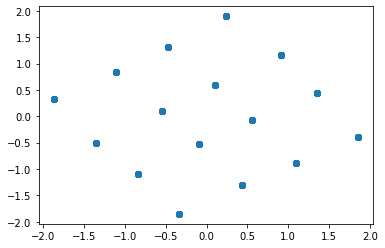

In [20]:
plt.scatter(out[:, 0], out[:, 1])

In [24]:
np.unique(out, axis=0)

array([[-1.8711809 ,  0.32565695],
       [-1.3585825 , -0.4996402 ],
       [-1.1085477 ,  0.83373606],
       [-0.8364035 , -1.0944949 ],
       [-0.5489701 ,  0.10573792],
       [-0.47662976,  1.3167603 ],
       [-0.33961627, -1.852976  ],
       [-0.0958127 , -0.52523977],
       [ 0.10501074,  0.590277  ],
       [ 0.23999888,  1.899241  ],
       [ 0.43913144, -1.312808  ],
       [ 0.5583426 , -0.07389611],
       [ 0.91414523,  1.1692723 ],
       [ 1.0956138 , -0.88391596],
       [ 1.353309  ,  0.44953963],
       [ 1.8568527 , -0.39312708]], dtype=float32)